In [1]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Annotated, Optional, List, Dict
from operator import add

from langchain.vectorstores import FAISS
from langchain.document_loaders import DirectoryLoader, TextLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_openai import OpenAIEmbeddings
from rich import print

In [2]:
# vec = FAISS.load_local('faiss_embeddings_v1/', 
#                        OpenAIEmbeddings(api_key=os.environ['API_KEY'], model='text-embedding-ada-002', show_progress_bar=True),
#                        allow_dangerous_deserialization=True)

In [3]:
# docs_to_search = ['gdrive_content/Copy of MUFG GenAI sharing 19th June_enhanced.md']

# docs = vec.similarity_search('what GenAI use cases are shared with MUFG?',k=10, 
#                       filter=lambda x: x['source'] in docs_to_search)

## Dir analysis agent & some functions

In [2]:
from langgraph.constants import Send
from itertools import repeat
from typing import Dict, Union, Set
from functools import reduce
import re
import os,sys
import json

from langchain.prompts import ChatPromptTemplate


import pydantic
from pydantic import BaseModel, Field
from typing import List, Literal


class DictLikeModel(BaseModel):
    def __getitem__(self, item):
        return getattr(self, item)
    
    def get(self, item, default=None):
        return getattr(self, item, default)


    
    
def render_answer(structured_answer):
    from IPython.display import display, Markdown, Image
    
    display(Markdown(f"# Summary\n{structured_answer['summary']}"))
    display(Markdown(f"**Status:** {structured_answer['status']}"))
    display(Markdown(f"**Details:** {structured_answer['detailed_answer']}"))
    
    
    for item in structured_answer['answer_list']:
        display(Markdown(f"### {item['title']}"))
        display(Markdown(item['description']))
        for img in item['images']:
            display(Image(filename=img))
    
    if structured_answer['additional_info']:
        display(Markdown(f"## Additional Information\n{structured_answer['additional_info']}"))

In [3]:
# Usage (in a Jupyter notebook or similar environment):
# result = process_query("What are the DAX models?")
# render_answer(result['final_answer'])

import tiktoken

def estimate_tokens_for_files(file_paths: List[str], model: str = "gpt-4o", total_only=False) -> Dict[str, Union[int, None]]:
    try:
        encoding = tiktoken.encoding_for_model(model)
    except KeyError:
        encoding = tiktoken.get_encoding("cl100k_base")  # Default to GPT-4 encoding

    token_counts = {}
    total_tokens = 0

    for file_path in file_paths:
        try:
            with open(file_path, 'r', encoding='utf-8') as file:
                content = file.read()
                token_count = len(encoding.encode(content))
                token_counts[file_path] = token_count
                total_tokens += token_count
        except Exception as e:
            print(f"Error processing file {file_path}: {str(e)}")
            token_counts[file_path] = None

    # Add the total to the dictionary
    token_counts['total'] = total_tokens
    
    if total_only:
        return token_counts['total']
    return token_counts

In [4]:
def get_file_details_in_dir(dir_name, ext_types=['md', 'json', 'txt'], md_total_len=50000):
    md_count = len([md for md in os.listdir(dir_name) if md.endswith('.md')])
    
    if md_count > 1:
        max_len = md_total_len // md_count
    else: max_len = md_total_len
    
    
    files = [f for f in os.listdir(dir_name) if (not os.path.isdir(os.path.join(dir_name, f)))
             and any(f.split('.')[-1]==ext for ext in ext_types)]
    # print(files)
    return [
        {f: {
            'size': os.path.getsize(os.path.join(dir_name, f)),
            'content': load_content(os.path.join(dir_name, f), max_len=max_len)
        }} for f in files]

In [5]:
def load_content(file_path, max_len=50_000):

    file_ext = file_path.split('.')[-1]

    if file_ext == 'md' or file_ext=='txt':
        with open(file_path, 'r') as f:
            return f.read()[:max_len]

    elif file_ext=='json':
        with open(file_path, 'r') as f:
            data = json.load(f)

        return data

    else:
        return f'Loading content from {file_ext} not supported'


def get_sub_dirs(dir_name):
    sub_dirs = [os.path.join(dir_name, d) for d in os.listdir(dir_name) if os.path.isdir(os.path.join(dir_name,d))]
    
    return sub_dirs


def get_sub_dirs_from_nested_dict(nested_dict, dir_name):
    parts = dir_name.split('/')
    for part in parts[1:]: # exclude root
        curr_dict = nested_dict[part]
        
    return [c for c,v in curr_dict.items() if v]
    

def create_nested_structure(root_dir: str, dir_only: bool = False, exclude_pattern: str = '') -> Dict:
    exclude_regex = re.compile(exclude_pattern) if exclude_pattern else None
    
    def should_include(name: str) -> bool:
        return not exclude_regex or not exclude_regex.search(name)

    def recurse(path: str) -> Dict:
        result={}
        for item in os.listdir(path):
            if should_include(item):
                item_path = os.path.join(path, item)
                if os.path.isdir(item_path):
                    result[item] = recurse(item_path)
                elif not dir_only:
                    result[item] = {}
        return result

    return recurse(root_dir)

In [6]:
class ReconState(DictLikeModel):
    original_query: Optional[str] = ''
    enhanced_query: Optional[str] = ''
    
    next_dir_batch: Optional[List] = []
    dirs_to_analyze: Optional[Annotated[List, add]] = []
    recursive_search_root_dirs: Annotated[List, add] = []
    
    # analyzed_dirs: Annotated[Set, add] 
    
    dir_status: Annotated[List, add] = []
    
    final_answer: Optional[str] = ''
    
class DirState(TypedDict):
    query: str
    dir_name: str
    file_details: str
    sub_dirs: List[str]
    docs_to_deepdive: List[str]
    decision: str
    reasoning: str
    answer: str
    

def flatten(list_of_lists):
    return [item for sublist in list_of_lists for item in sublist]

def get_next_batch(state: Dict) -> Dict:
    
    if state.get('dir_status'):  # not first batch
        explored_dirs = set(s.get('dir_name') for s in state['dir_status'])
        
        drill_dirs = [d['dir_name'] for d in state['dir_status'] if d.get('decision') == 'DRILL_SUBDIR']
        next_dir_batch = flatten([get_sub_dirs(d) for d in drill_dirs])
        next_dir_batch = [d for d in next_dir_batch if d not in explored_dirs]
        # print(f'next batch: {next_batch_dir}')
    else:
        print('analyzing root dirs')
        next_dir_batch = list(set(state['recursive_search_root_dirs']))
        # print(next_dir_batch)
    
    return {
        'dirs_to_analyze': next_dir_batch,  # add-only list
        'next_dir_batch': next_dir_batch,  # overwrite list for current batch
    }

def should_continue(state: Dict) -> bool:
    return bool(state.get('next_dir_batch'))

def prepare_to_analyze(state: ReconState):
    # print(state['next_dir_batch'])
    
    dir_batch = state['next_dir_batch']
    
    send_list = [Send('analyze_dir', {
        'dir_name': d, 
        'query':q, 
        'sub_dirs': get_sub_dirs(d),
        'file_details': get_file_details_in_dir(d)
    })  for (d,q) in zip(dir_batch, repeat(state['enhanced_query']))]
    
    return send_list

In [7]:
def analyze_dir(state, model='gpt-4o'):
    dir_name = state['dir_name']
    sub_dirs = state['sub_dirs']
    # print(f'analyzing {dir_name}, sub_dirs {sub_dirs}')
    
    # llm = get_llm(model=state.get('llm_model', model))

    # print(state['dir_name'], state['sub_dirs'])
    analyze_dir_prompt = ChatPromptTemplate.from_messages([
        ('user', """
        You are one of the agents dispatched to look at a specific directory {dir_name}, together you will provide insights to address the overall user query: {query}
        You will be provided with the directory structure(depth=1), directory content if any, as well as directory metadata which might contain information such as a description and/or summary,
        Note that if there are relevant sub_directories, they would be attended to by another agent.        
        Please analyze the markdown content if any, alongside with the metadata json, in order to answer the query
        Details of files in the Dir(Not in cluding sub-dirs, which would be handled by next batch of agents if needed: {file_details}
        If you require deep dive to files other than page content(content.md), You can do so via calling a tool to either read markdown or do vector search
        Note that content is truncated at 50000 characters. If you deem that it is necessary to do vector search beyong provided content,
        
        YOU should look at the sub directories to examine CAREFULLY whether the query can POTENTIALLY be answered with info that might be present in sub directories, before concluding not answerable
        e.g. if subdirs are model inventories, it might contain model specific info such as development date, developer, status;
        if subdirs are specific models, they might include very detailed information about model evaluation and performance etc.
        IF sub_dirs are empty, DO NOT RETURN DRLL_SUBDIR
        
        ** IMPORTANT: ALWAYS THINK STEP BY STEP with the question and record in reasoning, before you give an answer
        ** IMPORTANT: READ any markdown table ACCURATELY and CAREFULLY!!

        your response MUST be a JSON AND NOTHING ELSE(NO ```json formatting!) with the following keys:
        - dir_name [ABSOLUTE DIR PATH, DO NOT INCLUDE slash(/) in front of path]
        - decision: ANSWERABLE|NOT_ANSWERABLE|DRILL_SUBDIR|DEEP_DIVE_DOCS
        - reasoning (reasoning or insights while exploring the directory)
        
        - final_answer (only if the query is ANSWERABLE using the current content)
        - docs_to_deepdive (optional, only if there are relevant documents which we should read in full or do vector search against, we will use a dedicated doc analysis agent, provide FULL DOCUMENT PATH)
        * Note: for docs_to_deepdive, if there are .md and _enhanced.md versions of the SAME document, ONLY include _enhanced.md version
        
        YOU SHOULD ALWAYS DOUBLE CHECK YOUR WORK AGAINST REQUIREMENTS TO ENSURE CORRECTNESS
        IGNORE irrelevant dirs such as .*
        DO NOT ASSUME ANYTHING, ALWAYS BE FACTUAL, ONLY ANSWER ACCORDING TO CONTEXT
        
        CONSIDER TWICE BEFORE CONCLUDING NOT_ANSWERABLE, LOOK AT SUBDIRS
    
        
        """)
    ])
    
    analyze_chain = analyze_dir_prompt | llm.with_structured_output(DirState, method='json_mode')
    response = analyze_chain.invoke(
        dict(query=state['query'], 
             dir_name=state['dir_name'],
             sub_dirs=state['sub_dirs'],
             file_details=state['file_details']
        )
    )
    
    print(response['dir_name'], response['decision'])
    
    return {'dir_status': [response]}

In [8]:
from langchain.prompts import ChatPromptTemplate
from langchain.output_parsers import PydanticOutputParser
from pydantic import BaseModel, Field
from typing import List, Optional

class StructuredAnswer(BaseModel):
    reasoning: str = Field(description="Scratchpad for step-by-step reasoning")
    
    summary: str = Field(description="A concise summary of the findings")
    status: str = Field(description="Overall status of the query (e.g., 'Fully Answered', 'Partially Answered', 'Unable to Answer')")
    detailed_answer: str = Field(description="A detailed answer to the user's query")
    answer_list: Optional[List] = Field(description='A list of relevant answers if applicable', default=[])
    answer_dict: Optional[Dict] = Field(description='A dict of relevant answers if applicable', default={})
    
    additional_info: Optional[str] = Field(description="Any additional information or caveats")

def consolidate_answer(state, model='gpt-4o'):
    # llm = get_llm(model=state.get('llm_model', model))

    query = state.get('query', '')    
    
    prompt = ChatPromptTemplate.from_template("""
    You are an AI assistant tasked with synthesizing information from multiple directory analyses to answer a user's query. Your goal is to provide a clear, structured, and informative response.
    * IF the question is relevant but not answerable, state clearly
    ** IF the question is IRRELEVANT, as advised in planner instructions, write a DEADPOOL style SACARSTIC and FUNNY response in detailed_answer **

    User Query: {query}

    Insights from Directory Analyses:
    {dir_insights}
    
    Insights from Documents Analysis:
    {doc_insights}
    
    Instructions from query planner:
    {planner_instructions}
    

    Instructions:
    1. Carefully analyze the information provided from all directory analyses.
    2. Synthesize a comprehensive answer to the user's query.
    3. If the user has specified a particular format or structure for the answer, adhere to it strictly.
    4. If no specific format is requested, organize the information in a clear and readable manner.
    5. Ensure that your answer directly addresses the user's query.
    6. If there are any uncertainties or gaps in the information, acknowledge them.
    7. If relevant, include a list of specific models or entities mentioned in the analyses.

    Please provide your answer in the following JSON structure and NOTHING ELSE:
        
    Always reason STEP BY STEP; use doc insights and dir insights as REFERENCE,
    DOUBLE VALIDATE that they answered question ACCURATELY
    USE the reasoning field for your scratchpad, ** ONLY OUTPUT JSON **
    
    - reasoning: str Scratchpad for reasoning
    - summary: A brief overview of the findings.
    - status: Indicate whether the query was fully answered, partially answered, or unable to be answered.
    - detailed_answer(Str): Provide a comprehensive STRING response to the query, format in markdown, including markdown tables
    - answer_list(Optional): A list of items, each containing:
      - title: A title for this item
      - description: A description or explanation
      - images: A list of image information (path and optional caption)
    - additional_info: Include any caveats, limitations, or extra context that might be useful.
    

    Remember to adjust your response style based on any specific instructions in the user's query. If the query asks for a particular format (e.g., bullet points, table), please use that format in the detailed answer section.

    """)

    # Prepare the output parser
    # parser = PydanticOutputParser(pydantic_object=StructuredAnswer)

    # Combine the prompt and parser
    chain = prompt | llm.with_structured_output(StructuredAnswer, method='json_mode')

    # Generate the response
    response = chain.invoke({
        "query": query, 
        "dir_insights": [d for d in state.get('dir_status') if d['decision']=='ANSWERABLE'],
        "doc_insights": state.get('doc_status'),
        "planner_instructions": state.get('planner_instructions')
    
    })
    
    print(response)    

    # Return the structured answer
    return {'final_answer': response}

## Get LLM 

In [9]:
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from functools import partial

load_dotenv()


def get_llm(api_key, model='gpt-4o', temperature=0):
    model_map = {
        'gpt-4o': 'openai/gpt-4o',
        'gpt-4o-mini': 'openai/gpt-4o-mini',
        'claude3.5': 'aws/anthropic.claude-3-5-sonnet-20240620-v1:0',
    }
    
    return ChatOpenAI(
        api_key=api_key,
        model = model_map.get(model),
        base_url='https://public-api.grabgpt.managed.catwalk-k8s.stg-myteksi.com/unified/v1/',
        temperature=temperature
    )
    
API_KEY = "8587639c-f154-46d6-b4b4-17e9ff3bed60"

get_llm = partial(get_llm, api_key=API_KEY)

llm_map = {'gpt-4o': get_llm(model='gpt-4o'), 'claude3.5': get_llm(model='claude3.5')}

In [10]:
global llm
llm = llm_map['claude3.5']

In [11]:
llm

ChatOpenAI(client=<openai.resources.chat.completions.Completions object at 0x7f8718194130>, async_client=<openai.resources.chat.completions.AsyncCompletions object at 0x7f871819ca90>, model_name='aws/anthropic.claude-3-5-sonnet-20240620-v1:0', temperature=0.0, openai_api_key=SecretStr('**********'), openai_api_base='https://public-api.grabgpt.managed.catwalk-k8s.stg-myteksi.com/unified/v1/', openai_proxy='')

## Query Planner


In [12]:
class QueryPlan(DictLikeModel):
    original_query: Optional[str]
    enhanced_query: Optional[str]
    reasoning: Optional[str]
    relevant_documents: Optional[List[str]] = []
    recursive_search_root_dirs: Optional[List[str]] = []
    
    planner_instructions: Optional[str]
    recommended_system: Optional[Literal["ReCon", "Targeted", "Hybrid", "None"]]
    complexity: Optional[Literal["High", "Medium", "Low", "None"]]

def query_planner(state, model='gpt-4o'):
    # llm = get_llm(model=state.get('llm_model', model))

    
    match_prompt = ChatPromptTemplate.from_messages([
        ('user', """
        Your task is to analyze the query, look at relevant directories from the wiki and Google Drive content, and determine the best approach to answer the query.

        Query: {query}
        Directory Structure: {dir_tree_dict}

        1. Analyze the query and the directory structure.
        2. Enhance the query to be more clear and structured
        2. Identify specific directories that are likely to be relevant to the query.
        3. Provide a logical description of how to approach answering the query.
        4. Determine the complexity of the query and the recommended system to use.
        5. Provide instructions for the agents which will investigate the directories.
        
        * Note: original HTML and markdown documents are likely already been converted to .md and might have been enhanced with image transcriptions(_enhanced.md)
                we only have to look at the most enhanced document(_enhanced.md > .md > [.pdf/.html], therefore, only include the best version of each document
    

        Guidelines:
        - Directories should be in ABSOLUTE PATH format.
        - Include parent dirs if they contain relevant inventory or summary information.
        - Do not include a slash (/) at the start of paths.
        - List directories in a parent-child page manner conducive for a tree traversal search.
        - If no relevant paths are found, clearly state this in your reasoning and return an empty list for relevant_dirs.
        - Consider the query complexity:
          * High: Requires deep analysis, multiple directories, or complex reasoning.
          * Medium: Involves multiple straightforward steps or moderate analysis.
          * Low: Can be answered with simple lookups or minimal processing.
        - Recommend a system based on complexity:
          * ReCon: For hierachical queries requiring recursive map-reduce exploration and summarizations.
              - e.g. summarize the development date and developer of each DAX Models and report in a markdown table
          * Targeted: For targetabled queries which could be address by one or a few documents which can be idnetified clearly
              - e.g. What is the key development steps of a credit score model?
          * Hybrid: a combination of both, we will process directories first then documents
        - Proirotize COMPLETENESS AND ACCURACY of answers, use targeted only if you are CONFIDENT that answers lie within a specific documents
              
        Your response MUST be a JSON with the following keys:
        - original_query: The original query
        - enhanced_query: Enhanced query
        - reasoning: Your analysis and approach
        - relevant_documents(Opitonal): List of FULL PATHS of relevant documents for targeted search
        - recursive_search_root_dirs(Optional): List of FULL root directories for recursive search, assemble FULL PATH
        - planner_instructions(str): Insights or instructions/caveats of knowledge base structure e.g. where the info might be available, to downstream agents, note that each agent handles one dir/doc, we devide and conquer,
           ** if query is irrelavant, state so, agents won't be called **
        - recommended_system: "ReCon" or "Targeted" or "Hybrid" or "None"
        - complexity: "High", "Medium", or "Low"

        DOUBLE CHECK THAT YOU HAVE INCLUDED ** ALL RELEVANT DIRECTORIES ** or ** ALL RELEVANT DOCS ** AND PROVIDED ACCURATE RECOMMENDATIONS.
        IT'S BETTER TO INCLUDE EXTRA THAN MISSING OUT! When in doubt, default to ROOT DIRs
        """)
    ])
        
    match_chain = match_prompt | llm.with_structured_output(QueryPlan, method='json_mode')
    
    response = match_chain.invoke(
        dict(query=state['query'], 
             dir_tree_dict=state['dir_tree_dict']
        )
    )
    
    print(response)
    
    return response

## Create dict representing directory structures to pass into graph

In [13]:
dirs_to_analyze=['wiki_content', 'gdrive_content']

dir_dict = {d: create_nested_structure(d,exclude_pattern='image|.ipy') for d in dirs_to_analyze}

In [14]:
dir_dict

{'wiki_content': {'Dax Unified AB-Score Model Inventory_510865990': {'dax-abscore-id-2w-231101_526338294': {'content.md': {},
    'metadata.json': {},
    'dax-abscore-id-2w-231101-99feats (1).html': {},
    'content.md.metadata.json': {},
    'dax-abscore-id-2w-231101-99feats (1).md': {},
    'dax-abscore-id-2w-231101-99feats (1).md.metadata.json': {},
    'content.html': {}},
   'dax-abscore-th-2w-230801_510866096': {'dax-th-2w-abscore-mob9-230801-adw (1).html': {},
    'content.md': {},
    'metadata.json': {},
    'dax-th-2w-abscore-mob9-230801-adw (1).md': {},
    'content.html': {}},
   'dax-abscore-ph-2w-231001_526338151': {'content.md': {},
    'dax-abscore-ph-2w-231001-105feats (1).md': {},
    'metadata.json': {},
    'dax-abscore-ph-2w-231001-105feats (1).html': {},
    'content.html': {}},
   'content.md': {},
   'dax-abscore-my-2w-231001_510866040': {'content.md': {},
    'metadata.json': {},
    'dax-abscore-my-2w-231001-adw-89feats (1).html': {},
    'dax-abscore-my-2w-2

## Planner examples

In [29]:
from rich import print

plan = query_planner({
    'query': 'what genai use cases are presented during MUFG sharing, provide absolute path to the relevant images',
    'dir_tree_dict':dir_dict
})

QueryPlan(
    original_query='what genai use cases are presented during MUFG sharing, provide absolute path to the relevant 
images',
    enhanced_query='What GenAI use cases were presented during the MUFG sharing session? Provide the absolute paths
to any relevant images or visual content related to these use cases.',
    reasoning="The query is specifically asking about GenAI use cases presented during an MUFG sharing session. 
Based on the directory structure, there's a document that seems directly relevant: 'Copy of MUFG GenAI sharing 19th
June.md' in the gdrive_content directory. This document is likely to contain the information we're looking for, 
including any images related to the GenAI use cases. Since we're asked to provide absolute paths to relevant 
images, we should focus on this document as it's the most likely source of the required information.",
    relevant_documents=['gdrive_content/Copy of MUFG GenAI sharing 19th June.md'],
    recursive_search_root_dirs=[],
    planner_instructions="Focus on the 'Copy of MUFG GenAI sharing 19th June.md' document. Look for sections or 
content that discuss GenAI use cases. Pay special attention to any images or visual content within the document 
that illustrate these use cases. Extract and provide the absolute paths to these images if they exist within the 
document structure. If no images are found, report on the GenAI use cases discussed in the text.",
    recommended_system='Targeted',
    complexity='Medium'
)

In [24]:
from rich import print

plan = query_planner({
    'query': 'what are the active DAX models in SG? include all types',
    'dir_tree_dict':dir_dict
})

QueryPlan(
    original_query='what are the active DAX models in SG? include all types',
    enhanced_query='List all active DAX models for Singapore (SG), including A-Score, B-Score, and other types such
as PD/LGD models. Provide details on model versions and dates if available.',
    reasoning="To answer this query comprehensively, we need to look at multiple directories that contain 
information about DAX models for Singapore. The main relevant directories are under the 'wiki_content' folder, 
specifically in the A-Score, B-Score, and LGD Models sections. We should also check the Unified AB-Score Model 
Inventory for any combined or updated information. Since we're looking for all types of active models, it's best to
search through these directories recursively to ensure we don't miss any relevant information.",
    relevant_documents=[],
    recursive_search_root_dirs=[
        'wiki_content/Dax Unified AB-Score Model Inventory_510865990',
        'wiki_content/01.A-Score_290208869/Dax A-Score Model Inventory_292635806',
        'wiki_content/02.Behaviour-Score_291414068/Dax Behaviour Score Model Inventory_291414077',
        'wiki_content/09. LGD Models_289658786/Dax PD LGD Models Inventory_291417516'
    ],
    planner_instructions="When searching through the directories, focus on files containing 'sg' or 'singapore' in 
their names. Look for the most recent versions of models, as these are likely to be the active ones. Pay attention 
to model version numbers and dates in file names or content. Collect information on all types of DAX models 
(A-Score, B-Score, PD/LGD) for Singapore. If you find summary documents or inventory lists, these may provide a 
comprehensive overview of active models.",
    recommended_system='ReCon',
    complexity='Medium'
)

## Doc analysis agent

In [18]:
from langchain_community.document_loaders import UnstructuredMarkdownLoader
from langchain_text_splitters import MarkdownHeaderTextSplitter


class TargetedState(DictLikeModel):
    relevant_documents: Optional[List[str]] = []
    original_query: Optional[str] = ''
    enhanced_query: Optional[str] = ''

    doc_status: Annotated[List, add] = []

class DocumentState(TypedDict):
    doc_path: str
    
    reasoning: str
    
    final_answer: str
    answer_list: List
    decision: str

def analyze_doc(state, vector_search_token_threshold=50_000, model='gpt-4o'):
    doc_path = state['doc_path']
    query = state['query']
    
    # llm = get_llm(model=state.get('llm_model', model))
    
    est_token_cnt = estimate_tokens_for_files([state['doc_path']], total_only=True)
    print(f'{doc_path} est. tokens: {est_token_cnt}')
    
    if est_token_cnt > vector_search_token_threshold:
        print('adding vector search')

        loader= UnstructuredMarkdownLoader(doc_path)
        data = loader.load()
        
        headers_to_split_on = [
            ("#", "Header 1"),
            ("##", "Header 2"),
            ("###", "Header 3")
        ]
        
        markdown_splitter = MarkdownHeaderTextSplitter(headers_to_split_on=headers_to_split_on, strip_headers=False)
        chunks = markdown_splitter.split_text(data[0].page_content)
        vec_db = FAISS.from_documents(chunks, OpenAIEmbeddings())
        
        vec_search_result = vec_db.similarity_search(query)
        state['vector_search_result'] = ';'.join([d.page_content for d in vec_search_result])
        
    analyze_doc_prompt = ChatPromptTemplate.from_messages([
        ('user', """
        You task is to analyze document {doc_path} in attempt to provide ACCURATE answers to query {query}.
        If the document is within an acceptable length, it will be read directly
        If the document exceeds length threshold, we will only read the document up to the length threshold to make sure it fits in context window
        Additionally,for long document, we will provide vector search result of the document against the query for additional context
        
        Document Content: {doc_content}
        Vector Search Result: {vec_search_result}
        
        ** IMPORTANT: ALWAYS THINK STEP BY STEP with the question and record in reasoning, before you give an answer
        ** IMPORTANT: READ any markdown table ACCURATELY and CAREFULLY!!
        
        * Note:
            if the doc is xxx_enhanced.md, you will see image transcriptions like:
            ![Image 21.1](Copy of MUFG GenAI sharing 19th June_images/image_p21_1.jpeg)

            > **Image Description**
            > 
            > **Title:** Party Popper Emoji
            > 
            > **Summary:** An image of a party popper emoji with confetti and streamers coming out of it, indicating celebration or party.
            > 
            > **Chart_data:** None
            
        Use the image description to identify relevant images. If you see emoji or icon, it's almost NEVER relevant


        
        your response MUST be a JSON AND NOTHING ELSE(NO ```json formatting!) with the following keys:
        - doc_path [ABSOLUTE DOCUMENT PATH, DO NOT INCLUDE slash(/) in front of path]
        - decision: ANSWERABLE|NOT_ANSWERABLE
        - reasoning
        - final_answer:str (only if the query is ANSWERABLE using the current content)
        - answer_list(Optional): A list of items, each containing:
              - title: A title for this item
              - description: A description or explanation
              - images: A list of image information (ABSOLUTE path and optional caption)
        
        """)
    ])
         
    analyze_doc_chain = analyze_doc_prompt | llm.with_structured_output(DocumentState, method='json_mode')
    
    response = analyze_doc_chain.invoke(
        dict(query=query, 
             doc_path=doc_path,
             doc_content=state['doc_content'],
             vec_search_result= state.get('vec_search_result', '')
        )
    )
    
    # print(response)
    
    
    return {'doc_status': [response]}
        

## Doc analyisis example

In [30]:
plan

QueryPlan(original_query='what genai use cases are presented during MUFG sharing, provide absolute path to the relevant images', enhanced_query='What GenAI use cases were presented during the MUFG sharing session? Provide the absolute paths to any relevant images or visual content related to these use cases.', reasoning="The query is specifically asking about GenAI use cases presented during an MUFG sharing session. Based on the directory structure, there's a document that seems directly relevant: 'Copy of MUFG GenAI sharing 19th June.md' in the gdrive_content directory. This document is likely to contain the information we're looking for, including any images related to the GenAI use cases. Since we're asked to provide absolute paths to relevant images, we should focus on this document as it's the most likely source of the required information.", relevant_documents=['gdrive_content/Copy of MUFG GenAI sharing 19th June.md'], recursive_search_root_dirs=[], planner_instructions="Focus on

In [31]:
plan.relevant_documents

['gdrive_content/Copy of MUFG GenAI sharing 19th June.md']

In [33]:
doc_analysis = analyze_doc(
    {
        'doc_path': 'gdrive_content/Copy of MUFG GenAI sharing 19th June_enhanced.md',
        'query': 'What GenAI use cases were presented during the MUFG sharing session? Provide the absolute paths to the relevant images.',
        'doc_content': load_content(plan.relevant_documents[0], 200_000)
    }, model='claude3.5'
)

gdrive_content/Copy of MUFG GenAI sharing 19th June.md est. tokens: 5872

In [35]:
doc_analysis

{'doc_status': [{'doc_path': 'gdrive_content/Copy of MUFG GenAI sharing 19th June.md',
   'decision': 'ANSWERABLE',
   'reasoning': "The document contains detailed information about several GenAI use cases presented during the MUFG sharing session. These use cases are clearly outlined in the document, including GrabGPT, Collections Agent's Quality Augmentation, Boost Loan Telesales Performance Effectiveness, Project Mystique, and Project Jarvis.",
   'final_answer': "The GenAI use cases presented during the MUFG sharing session were GrabGPT, Collections Agent's Quality Augmentation, Boost Loan Telesales Performance Effectiveness, Project Mystique, and Project Jarvis.",
   'answer_list': [{'title': 'GrabGPT',
     'description': 'An in-house UI and Governance wrapper on top of LLM models from various publishers, enabling enterprise-wide experimentation and adoption of LLM use-cases.',
     'images': [{'path': 'gdrive_content/Copy of MUFG GenAI sharing 19th June_images/image_p5_1.jpeg',


In [42]:
doc_analysis['doc_status'][0]['answer_list']

[{'title': 'GrabGPT',
  'description': 'An in-house UI and Governance wrapper on top of LLM models from various publishers, enabling enterprise-wide experimentation and adoption of LLM use-cases.',
  'images': [{'path': 'gdrive_content/Copy of MUFG GenAI sharing 19th June_images/image_p5_1.jpeg',
    'caption': 'GrabGPT Direct UI Access Point'},
   {'path': 'gdrive_content/Copy of MUFG GenAI sharing 19th June_images/image_p6_1.jpeg',
    'caption': 'GrabGPT Slack Bot Access Point'}]},
 {'title': "Collections Agents' Quality Augmentation",
  'description': "Augmenting the collections agents' call quality analysis using LLM models to boost agent effectiveness by providing structured feedback based on GenAI-powered analysis.",
  'images': [{'path': 'gdrive_content/Copy of MUFG GenAI sharing 19th June_images/image_p10_1.jpeg',
    'caption': 'Leveraging GPT / LLMs for Collections Speech Analysis'}]},
 {'title': 'Boost Loan Telesales Performance Effectiveness',
  'description': 'Using GenAI

**GrabGPT**

* An in-house UI and Governance wrapper on top of LLM models from various publishers, enabling enterprise-wide experimentation and adoption of LLM use-cases.

**GrabGPT Direct UI Access Point**

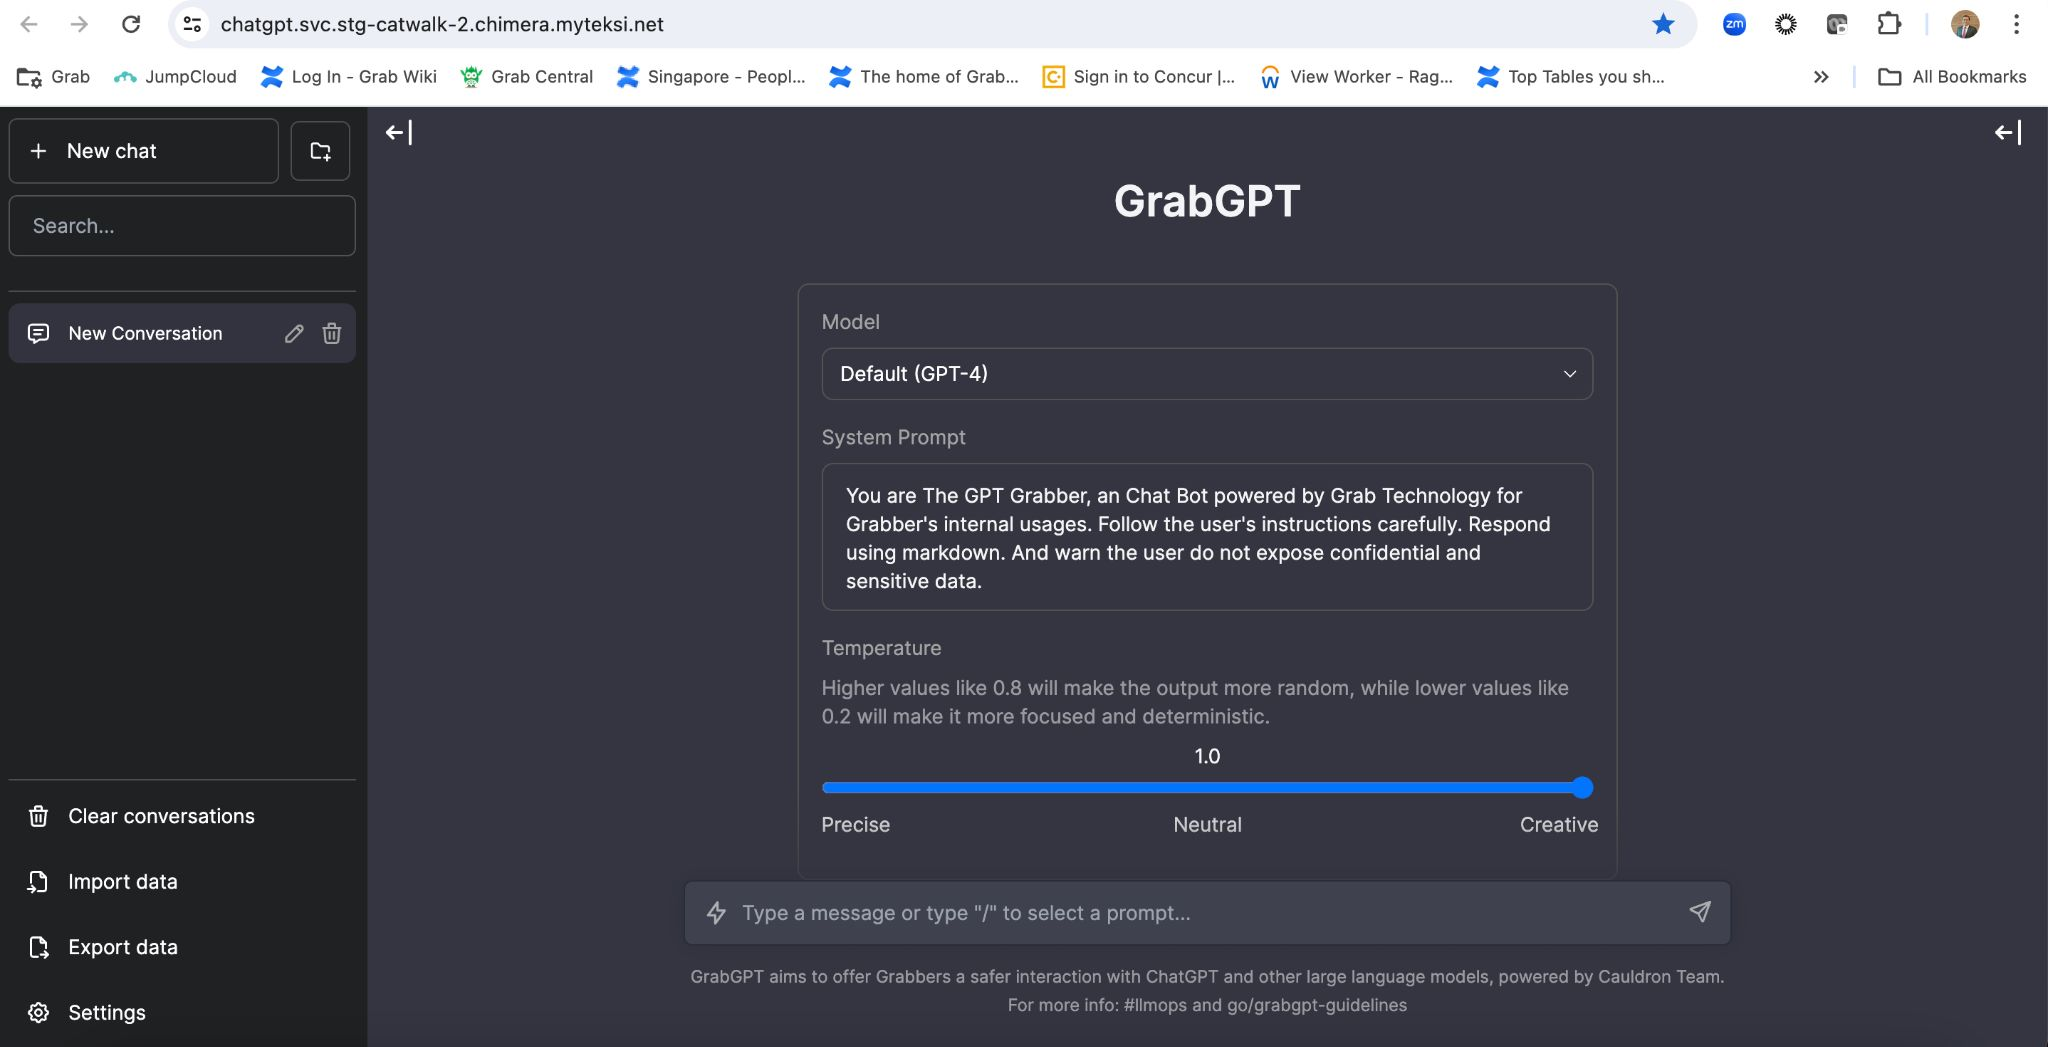

**GrabGPT Slack Bot Access Point**

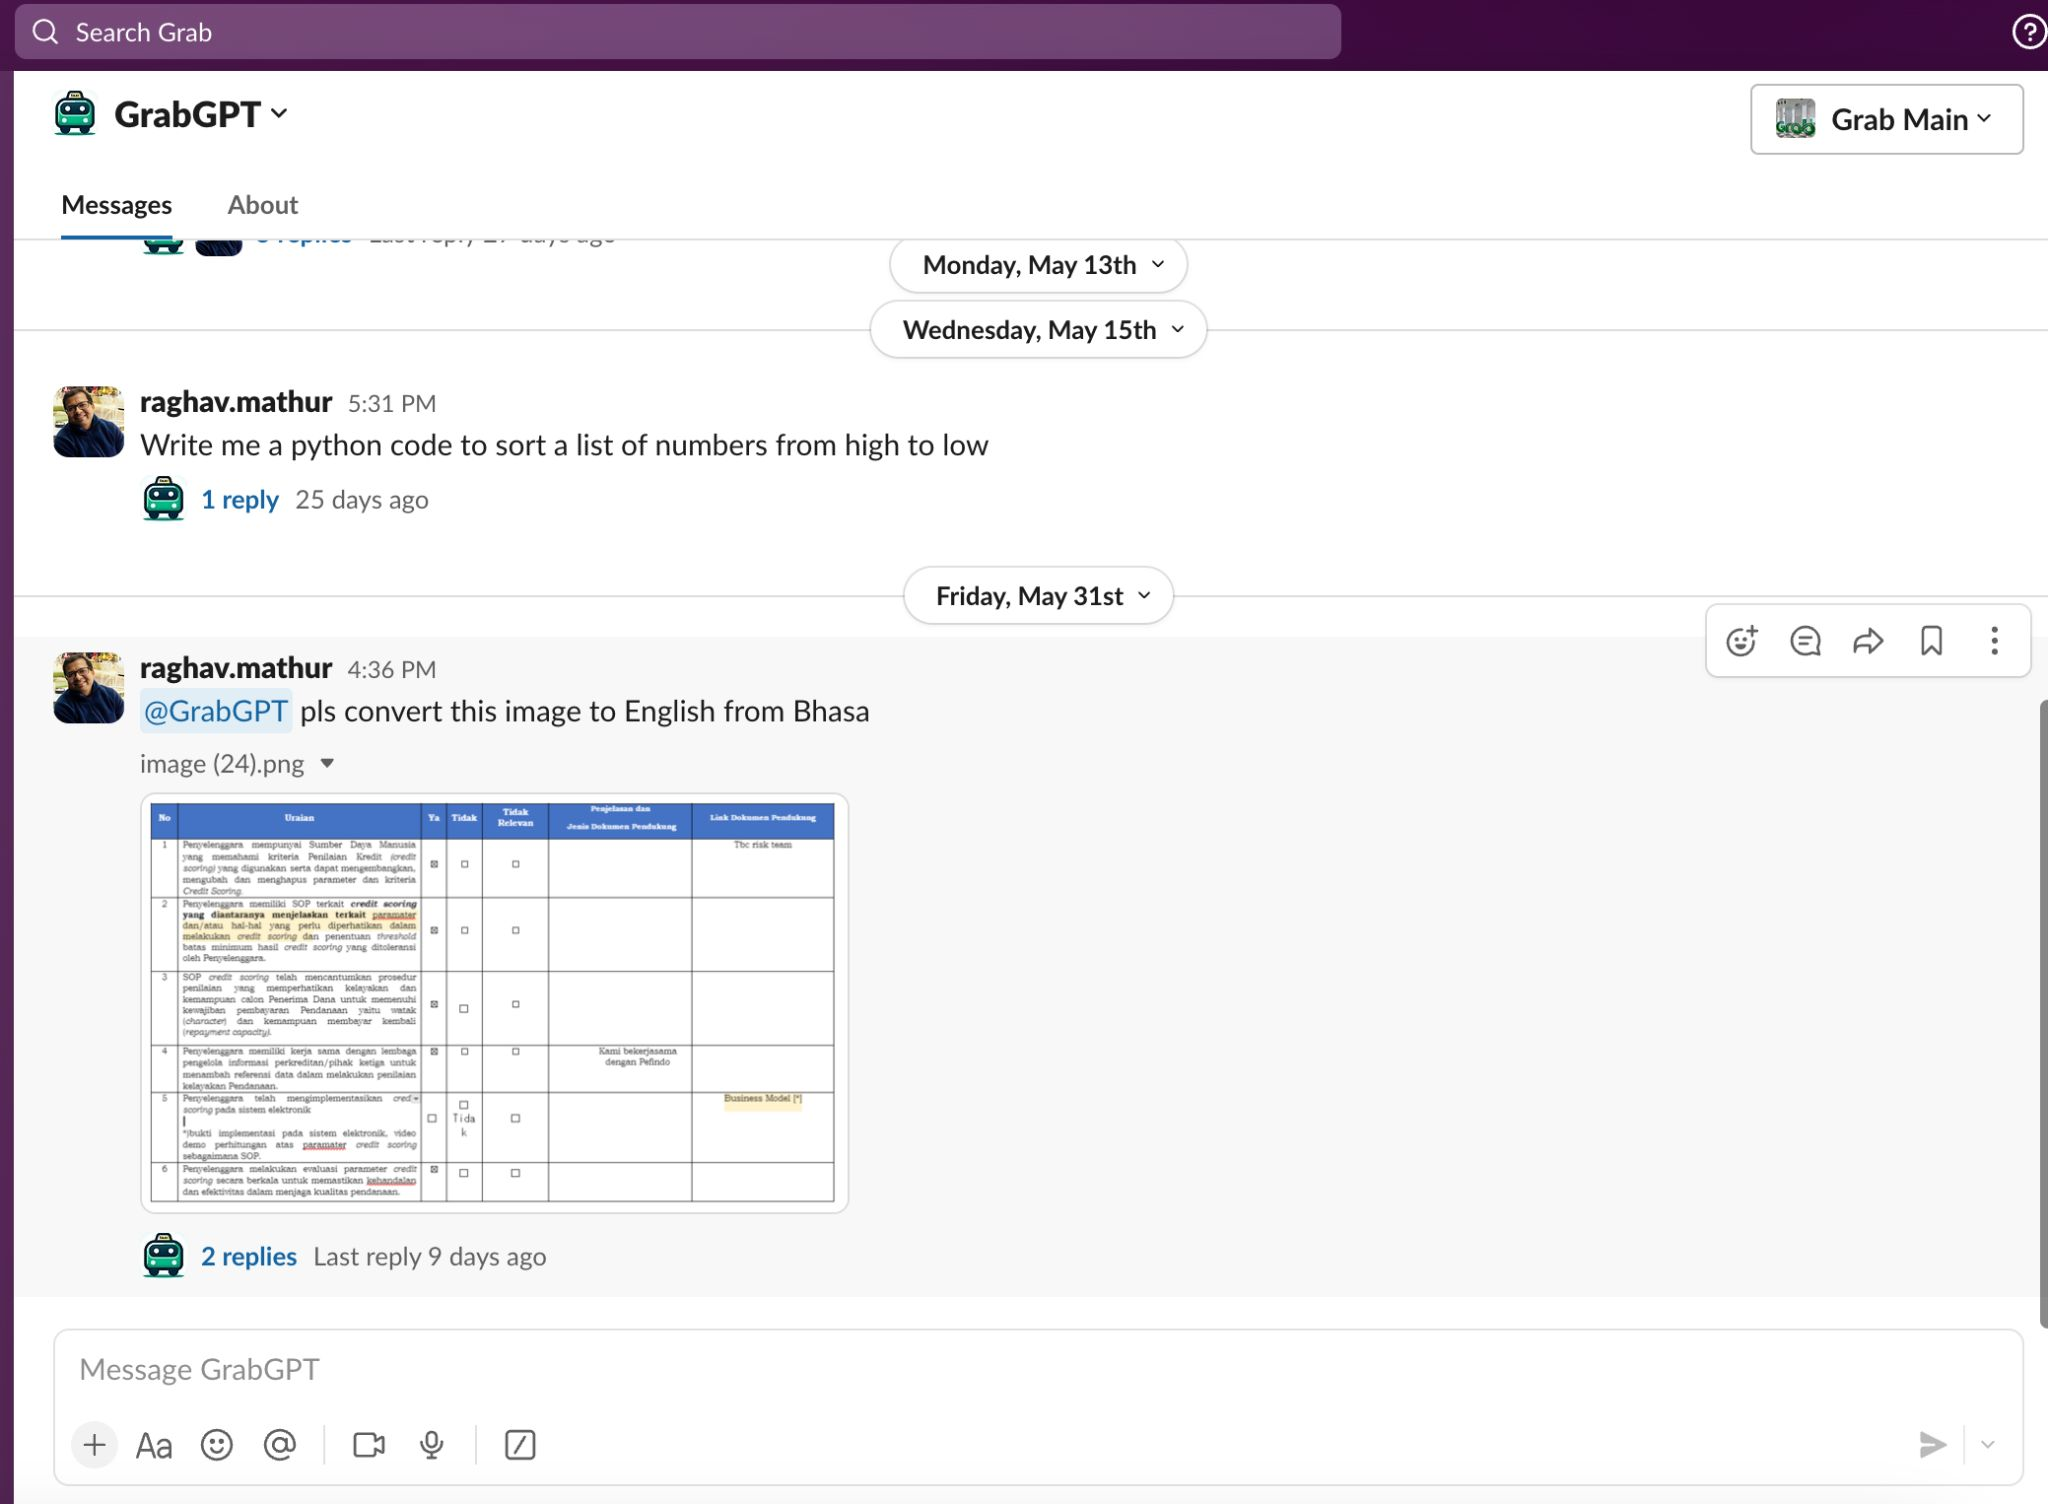

**Collections Agents' Quality Augmentation**

* Augmenting the collections agents' call quality analysis using LLM models to boost agent effectiveness by providing structured feedback based on GenAI-powered analysis.

**Leveraging GPT / LLMs for Collections Speech Analysis**

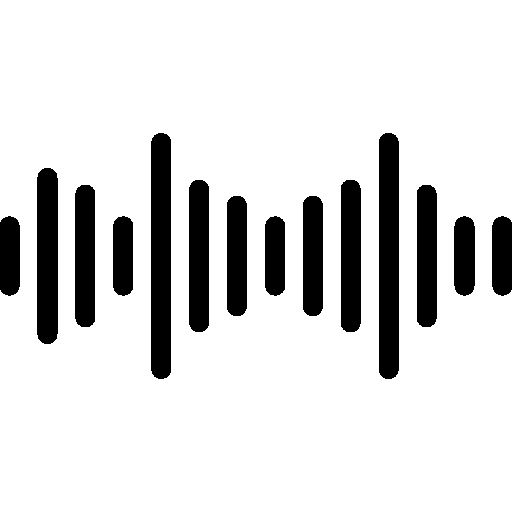

**Boost Loan Telesales Performance Effectiveness**

* Using GenAI to improve the effectiveness of telesales efforts by providing what-to-say and how-to-say insights to telesales agents.

**Boost Loan Telesales Performance Effectiveness Process**

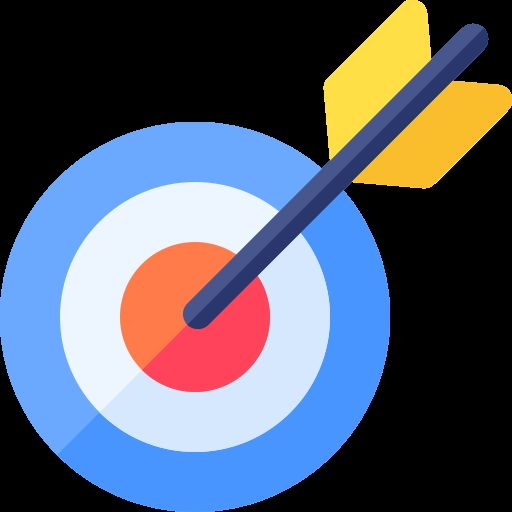

**Project Mystique**

* An in-house copywriter engine to build fast and cost-efficient marketing content (images, speech, marketing campaigns).

**Mystique Overview and Results**

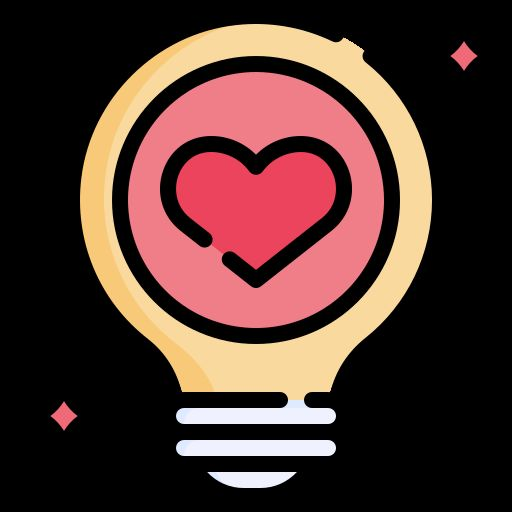

**Project Jarvis**

* Creation of insights from data mainly through insights/report building automation in specific areas and text-to-SQL queries implemented in Slack.

**Report Builder automated the MBR slides creation**

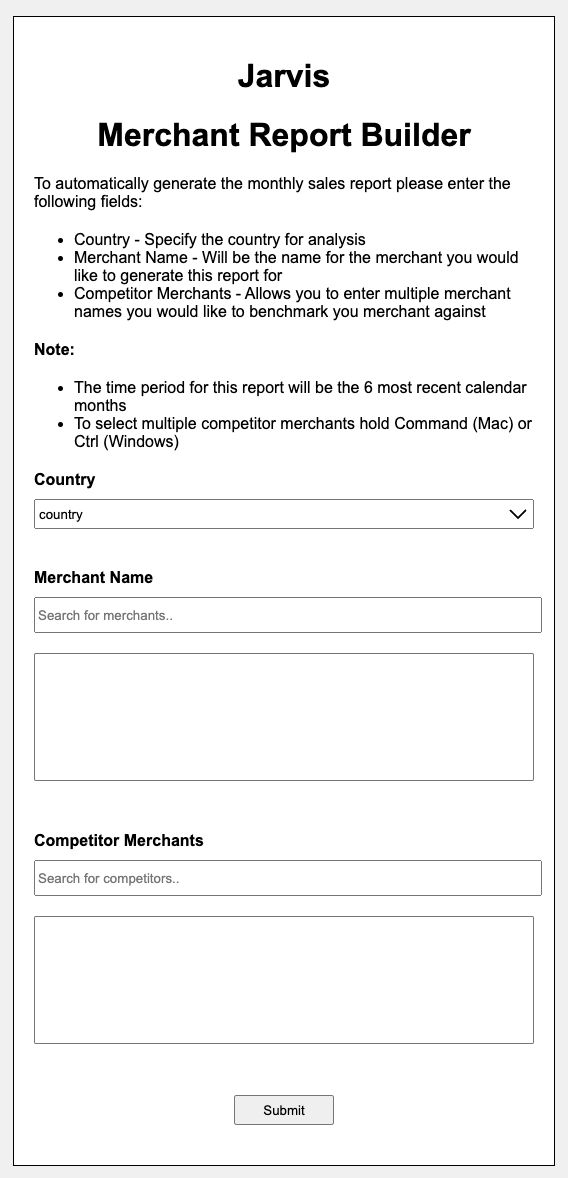

In [43]:
from IPython.display import display, Markdown, Latex,Image

for ans in doc_analysis['doc_status'][0]['answer_list']:
    title = ans['title']
    desc = ans['description']
    display(Markdown(f'**{title}**'))
    display(Markdown(f'* {desc}'))
    for image in ans['images']:
        caption = image['caption']
        display(Markdown(f'**{caption}**'))
        
        display(Image(filename=image['path']))



ChatOpenAI(client=<openai.resources.chat.completions.Completions object at 0x7f1506e16e30>, async_client=<openai.resources.chat.completions.AsyncCompletions object at 0x7f1506e20580>, model_name='openai/gpt-4o-mini', temperature=0.0, openai_api_key=SecretStr('**********'), openai_api_base='https://public-api.grabgpt.managed.catwalk-k8s.stg-myteksi.com/unified/v1/', openai_proxy='')

## Orchestrate Recursive-Concurrent (ReCon) Agent Sub-system for directory analysis

In [44]:
recon_graph = StateGraph(ReconState)

recon_graph.add_node('get_next_batch', get_next_batch)

recon_graph.add_node('analyze_dir', analyze_dir)

recon_graph.add_node('to_analyze_dir', lambda x:x)

recon_graph.add_node('agent_done', lambda x:x)

recon_graph.add_node('agent_start', lambda x:x)

recon_graph.set_entry_point('agent_start')

recon_graph.add_edge('agent_start', 'get_next_batch')


recon_graph.add_edge('analyze_dir', 'get_next_batch')

recon_graph.add_conditional_edges(
    "get_next_batch",
    should_continue,
    {
        True: "to_analyze_dir",
        False: "agent_done"
    }
)

recon_graph.add_conditional_edges("to_analyze_dir", prepare_to_analyze, ['analyze_dir'])


## Orchestrate Targeted Agent subsystem

In [45]:
def prepare_analyze_docs(state):
    print(state['relevant_documents'])
    
    docs_batch = state['relevant_documents']
    
    send_list = [Send('analyze_doc', {
        'doc_path': d, 
        'query':q, 
        'doc_content': load_content(d, 200_000)
    })  for (d,q) in zip(docs_batch, repeat(state['enhanced_query']))]
    
    return send_list


targeted_graph = StateGraph(TargetedState)


targeted_graph.add_node('analyze_doc', analyze_doc)

# targeted_graph.add_node('consolidate_answer', consolidate_answer)

targeted_graph.add_node('agent_start', lambda x: x)

targeted_graph.add_node('agent_done', lambda x: x)

targeted_graph.set_entry_point('agent_start')

targeted_graph.add_conditional_edges('agent_start', prepare_analyze_docs, ['analyze_doc'])

targeted_graph.add_edge('analyze_doc', 'agent_done')

targeted_graph.set_finish_point('agent_done')

# targeted_graph = targeted_graph.compile()




## Router to route agents

In [46]:
def router(state):
    dirs_analyzed = set([d['dir_name'] for d in state.get('dir_status', [])])
    dirs_to_analyze = set(state.get('recursive_search_root_dirs', []) + state.get('dirs_to_analyze',[]))
    dirs_remaining = dirs_to_analyze - dirs_analyzed
    docs_to_deepdive_from_dirs = set(reduce(add, [d.get('docs_to_deepdive', []) for d in last_state['dir_status']]))
    docs_remaining = set(state.get('relevant_documents', [])).union(docs_to_deepdive_from_dirs) - set([d['doc_path'] for d in state.get('doc_status', [])])
    
    
    if dirs_remaining:
        print(f'Routing to ReCon agent to analyze {dirs_remaining}')
        return 'recon'
    
    elif docs_remaining:
        print(f'Routing to targeted agents to analyze {docs_remaining}')
        return 'targeted'
    
    else:
        print('No more dirs or docs to analyze, to consolidate answer')
        return 'consolidate'

In [47]:

class InitialState(DictLikeModel):
    query: Optional[str] = ''
    dir_tree_dict: Optional[dict] = {}
    llm_model: Optional[str] = 'gpt-4o'

class OverallState(QueryPlan, ReconState, TargetedState, InitialState):
    pass

In [48]:
overall_graph = StateGraph(OverallState)

overall_graph.add_node(query_planner)

overall_graph.set_entry_point('query_planner')


overall_graph.add_node('ReCon Agent', recon_graph.compile())
overall_graph.add_node('Targeted Agent',targeted_graph.compile())

overall_graph.add_node('to_recon_agent', lambda x:x)
overall_graph.add_node('to_targeted_agent', lambda x:x)
overall_graph.add_node('to_consolidate_answer', lambda x:x)
overall_graph.add_node('to_decide_next_step', lambda x:x)


overall_graph.add_node('consolidate_answer', consolidate_answer)

overall_graph.add_edge('query_planner', 'to_decide_next_step')

overall_graph.add_conditional_edges(
    'to_decide_next_step', 
    router, 
    {
        'recon': 'to_recon_agent',
        'targeted': 'to_targeted_agent',
        'consolidate': 'to_consolidate_answer'
    }
)

overall_graph.add_edge('to_recon_agent', 'ReCon Agent')
overall_graph.add_edge('to_targeted_agent', 'Targeted Agent')
overall_graph.add_edge('to_consolidate_answer', 'consolidate_answer')

overall_graph.add_edge('ReCon Agent', 'to_decide_next_step')
overall_graph.add_edge('Targeted Agent', 'to_decide_next_step')

overall_graph.add_edge('consolidate_answer', END)

overall_graph = overall_graph.compile()

In [49]:
print(OverallState.model_fields)

{
    'query': FieldInfo(annotation=Union[str, NoneType], required=False, default=''),
    'dir_tree_dict': FieldInfo(annotation=Union[dict, NoneType], required=False, default={}),
    'llm_model': FieldInfo(annotation=Union[str, NoneType], required=False, default='gpt-4o'),
    'relevant_documents': FieldInfo(annotation=Union[List[str], NoneType], required=False, default=[]),
    'original_query': FieldInfo(annotation=Union[str, NoneType], required=True),
    'enhanced_query': FieldInfo(annotation=Union[str, NoneType], required=True),
    'doc_status': FieldInfo(annotation=List, required=False, default=[], metadata=[<built-in function add>]),
    'next_dir_batch': FieldInfo(annotation=Union[List, NoneType], required=False, default=[]),
    'dirs_to_analyze': FieldInfo(
        annotation=Union[Annotated[List, <built-in function add>], NoneType],
        required=False,
        default=[]
    ),
    'recursive_search_root_dirs': FieldInfo(annotation=Union[List[str], NoneType], required=False, default=[]),
    'dir_status': FieldInfo(annotation=List, required=False, default=[], metadata=[<built-in function add>]),
    'final_answer': FieldInfo(annotation=Union[str, NoneType], required=False, default=''),
    'reasoning': FieldInfo(annotation=Union[str, NoneType], required=True),
    'planner_instructions': FieldInfo(annotation=Union[str, NoneType], required=True),
    'recommended_system': FieldInfo(
        annotation=Union[Literal['ReCon', 'Targeted', 'Hybrid', 'None'], NoneType],
        required=True
    ),
    'complexity': FieldInfo(annotation=Union[Literal['High', 'Medium', 'Low', 'None'], NoneType], required=True)
}

## Full system example: ReCon expected 

In [51]:
dir_dict

{'wiki_content': {'Dax Unified AB-Score Model Inventory_510865990': {'dax-abscore-id-2w-231101_526338294': {'content.md': {},
    'metadata.json': {},
    'dax-abscore-id-2w-231101-99feats (1).html': {},
    'content.md.metadata.json': {},
    'dax-abscore-id-2w-231101-99feats (1).md': {},
    'dax-abscore-id-2w-231101-99feats (1).md.metadata.json': {},
    'content.html': {}},
   'dax-abscore-th-2w-230801_510866096': {'dax-th-2w-abscore-mob9-230801-adw (1).html': {},
    'content.md': {},
    'metadata.json': {},
    'dax-th-2w-abscore-mob9-230801-adw (1).md': {},
    'content.html': {}},
   'dax-abscore-ph-2w-231001_526338151': {'content.md': {},
    'dax-abscore-ph-2w-231001-105feats (1).md': {},
    'metadata.json': {},
    'dax-abscore-ph-2w-231001-105feats (1).html': {},
    'content.html': {}},
   'content.md': {},
   'dax-abscore-my-2w-231001_510866040': {'content.md': {},
    'metadata.json': {},
    'dax-abscore-my-2w-231001-adw-89feats (1).html': {},
    'dax-abscore-my-2w-2

In [50]:
last_state = overall_graph.invoke({
    'query': 'what are the active DAX unified A-B models in SG? list with their commisoned date and model developer, DO NOT INCLUDE DECOMMISSONED MODELS, RETURN THE MARKDOWN ROW ',
    'dir_tree_dict':dir_dict
})

QueryPlan(
    original_query='what are the active DAX unified A-B models in SG? list with their commisoned date and model 
developer, DO NOT INCLUDE DECOMMISSONED MODELS, RETURN THE MARKDOWN ROW',
    enhanced_query='List the active DAX unified A-B models for Singapore (SG) with their commissioned date and 
model developer. Exclude decommissioned models. Present the information in a markdown table row format.',
    reasoning="To answer this query, we need to focus on the DAX unified A-B models for Singapore. The most 
relevant directory appears to be the 'Dax Unified AB-Score Model Inventory' under the wiki_content. We should look 
for models specifically labeled for SG (Singapore) and ensure they are active. The information about commissioned 
date and model developer should be within the model details. We'll need to examine the content of relevant 
subdirectories to extract this information.",
    relevant_documents=[],
    recursive_search_root_dirs=['wiki_content/Dax Unified AB-Score Model Inventory_510865990'],
    planner_instructions="Focus on identifying Singapore (SG) models within the Dax Unified AB-Score Model 
Inventory. Look for model names containing 'sg' or 'SG'. Check if the model is active (not decommissioned) and 
extract the commissioned date and model developer information. Compile the information in a markdown table row 
format. If a model's status is unclear, include it and note the uncertainty.",
    recommended_system='ReCon',
    complexity='Medium'
)

NameError: name 'last_state' is not defined

In [27]:
print(last_state['final_answer'].detailed_answer)

NameError: name 'last_state' is not defined

## More Complicated ReCon Example using claude3.5

In [393]:
last_state = overall_graph.invoke({
    'query': 'what are the active DAX models in SG? these include unified A-B score, A-Score, B-Score, Cscore and PD-LGD list with their commisoned date and model developer,READ Markdown CAREFULLY, DO NOT INCLUDE DECOMMISSONED MODELS , Note that model inventory should be able to answer for most models',
    'dir_tree_dict':dir_dict
})

QueryPlan(
    original_query='what are the active DAX models in SG? these include unified A-B score, A-Score, B-Score, Cscore
and PD-LGD list with their commisoned date and model developer,READ Markdown CAREFULLY, DO NOT INCLUDE 
DECOMMISSONED MODELS , Note that model inventory should be able to answer for most models',
    enhanced_query='List all active DAX models in Singapore, including unified A-B score, A-Score, B-Score, 
C-Score, and PD-LGD models. For each model, provide the commissioned date and model developer. Exclude any 
decommissioned models. Focus on model inventory documents for comprehensive information.',
    reasoning='To answer this query, we need to search through multiple directories related to DAX models for 
Singapore. The main areas to focus on are A-Score, B-Score, C-Score, unified A-B score, and PD-LGD models. We 
should prioritize model inventory documents as they are likely to contain the most comprehensive information. The 
query requires gathering information from various model types, so we need to explore multiple directories.',
    relevant_documents=[],
    recursive_search_root_dirs=[
        'wiki_content/01.A-Score_290208869/Dax A-Score Model Inventory_292635806',
        'wiki_content/02.Behaviour-Score_291414068/Dax Behaviour Score Model Inventory_291414077',
        'wiki_content/03.Collections Models_373760201/DAX C-Score Model Inventory_407269192',
        'wiki_content/09. LGD Models_289658786/Dax PD LGD Models Inventory_291417516',
        'wiki_content/Dax Unified AB-Score Model Inventory_510865990'
    ],
    planner_instructions='1. Focus on Singapore (SG) specific models in each inventory.\n2. Look for active models 
only, paying attention to any mentions of decommissioning.\n3. For each relevant model, extract the commissioned 
date and model developer.\n4. Pay special attention to unified A-B score models, as they might be listed 
separately.\n5. Cross-reference information between different inventories to ensure completeness.\n6. If a model 
type is not found in its expected inventory, check other inventories as it might be categorized differently.',
    recommended_system='ReCon',
    complexity='High'
)

Routing to ReCon agent to analyze {'wiki_content/03.Collections Models_373760201/DAX C-Score Model 
Inventory_407269192', 'wiki_content/01.A-Score_290208869/Dax A-Score Model Inventory_292635806', 
'wiki_content/02.Behaviour-Score_291414068/Dax Behaviour Score Model Inventory_291414077', 'wiki_content/09. LGD 
Models_289658786/Dax PD LGD Models Inventory_291417516', 'wiki_content/Dax Unified AB-Score Model 
Inventory_510865990'}

analyzing root dirs

wiki_content/03.Collections Models_373760201/DAX C-Score Model Inventory_407269192 DRILL_SUBDIR

wiki_content/02.Behaviour-Score_291414068/Dax Behaviour Score Model Inventory_291414077 ANSWERABLE

wiki_content/09. LGD Models_289658786/Dax PD LGD Models Inventory_291417516 ANSWERABLE

wiki_content/Dax Unified AB-Score Model Inventory_510865990 ANSWERABLE

wiki_content/01.A-Score_290208869/Dax A-Score Model Inventory_292635806 ANSWERABLE

wiki_content/03.Collections Models_373760201/DAX C-Score Model Inventory_407269192/.ipynb_checkpoints DRILL_SUBDIR

wiki_content/03.Collections Models_373760201/DAX C-Score Model Inventory_407269192/DAX SG CScore 2W V7_407269780 
ANSWERABLE

wiki_content/03.Collections Models_373760201/DAX C-Score Model Inventory_407269192/DAX ID CScore 4W V7_407269959 
ANSWERABLE

wiki_content/03.Collections Models_373760201/DAX C-Score Model Inventory_407269192/DAX PH CScore 2W V7_409880311 
ANSWERABLE

wiki_content/03.Collections Models_373760201/DAX C-Score Model Inventory_407269192/DAX MY CScore 2W V7_409880301 
ANSWERABLE

wiki_content/03.Collections Models_373760201/DAX C-Score Model Inventory_407269192/DAX VN CScore 2W V7_409880337 
ANSWERABLE

wiki_content/03.Collections Models_373760201/DAX C-Score Model Inventory_407269192/DAX VN CScore 4W V7_407269851 
ANSWERABLE

wiki_content/03.Collections Models_373760201/DAX C-Score Model Inventory_407269192/DAX PH CScore 4W V7_407269974 
ANSWERABLE

wiki_content/03.Collections Models_373760201/DAX C-Score Model Inventory_407269192/DAX ID CScore 2W V7_409880284 
ANSWERABLE

wiki_content/03.Collections Models_373760201/DAX C-Score Model Inventory_407269192/DAX TH CScore 4W V7_407269859 
ANSWERABLE

wiki_content/03.Collections Models_373760201/DAX C-Score Model Inventory_407269192/DAX SG CScore 4W V7_407269209 
ANSWERABLE

wiki_content/03.Collections Models_373760201/DAX C-Score Model Inventory_407269192/DAX TH CScore 2W V7_409880329 
ANSWERABLE

wiki_content/03.Collections Models_373760201/DAX C-Score Model Inventory_407269192/DAX MY CScore 4W V7_407269839 
ANSWERABLE

No more dirs or docs to analyze, to consolidate answer

StructuredAnswer(
    reasoning="Let's analyze the information step by step:\n\n1. Unified AB-Score Models:\n   - 
[dax-abscore-sg-4w-230901] and [dax-abscore-sg-2w-230901]\n   - Both commissioned on November 01, 2023\n   - 
Developer: Kehua Lin\n   - Status: Active (Commissioned)\n\n2. A-Score Models:\n   - No active A-Score models 
specifically for Singapore\n   - The only active model (dax-ascore-ph-2w-v4) is listed under Philippines, likely an
error\n\n3. B-Score Models:\n   - No active B-Score models for Singapore\n   - The most recent model 
(dax-bscore-sg-2w-v5) was decommissioned on October 01, 2023\n\n4. C-Score Models:\n   - DAX SG CScore 4W V7 and 
DAX SG CScore 2W V7\n   - Both commissioned on April 6, 2022\n   - Developers: Ulysses Min Zhen Chong, Alan Choon\n
- Status: Active (deployed to production)\n\n5. PD-LGD Models:\n   - sg-dax-pd-lgd-v2\n   - Commissioned Date: 
November 01, 2022\n   - Developer: @Rhynade Ey See\n   - Status: Active (GreenCommissioned)\n\n   - dax-auto-pd-sg 
(under review)\n   - Developer: @Rhynade Ey See\n   - Status: BlueRISK Review (Not yet active)\n\nThis information 
covers all the model types requested in the query. The answer is comprehensive and accurate based on the provided 
directory analyses.",
    summary='The analysis identified active DAX models in Singapore across various categories including Unified 
AB-Score, C-Score, and PD-LGD models. No active A-Score or B-Score models were found specifically for Singapore.',
    status='Fully answered',
    detailed_answer='# Active DAX Models in Singapore\n\n## Unified AB-Score Models\n\n| Model Name | Commissioned 
Date | Model Developer | Status |\n|------------|-------------------|-----------------|--------|\n| 
[dax-abscore-sg-4w-230901] | November 01, 2023 | Kehua Lin | Commissioned |\n| [dax-abscore-sg-2w-230901] | 
November 01, 2023 | Kehua Lin | Commissioned |\n\n## A-Score Models\n\nNo active A-Score models specifically for 
Singapore were found in the inventory.\n\n## B-Score Models\n\nNo active B-Score models for Singapore. The most 
recent model (dax-bscore-sg-2w-v5) was decommissioned on October 01, 2023.\n\n## C-Score Models\n\n| Model Name | 
Commissioned Date | Model Developers | Status |\n|------------|-------------------|-------------------|--------|\n|
DAX SG CScore 4W V7 | April 6, 2022 | Ulysses Min Zhen Chong, Alan Choon | Active |\n| DAX SG CScore 2W V7 | April 
6, 2022 | Ulysses Min Zhen Chong, Alan Choon | Active |\n\n## PD-LGD Models\n\n| Model Name | Commissioned Date | 
Model Developer | Status |\n|------------|-------------------|-----------------|--------|\n| sg-dax-pd-lgd-v2 | 
November 01, 2022 | @Rhynade Ey See | GreenCommissioned (Active) |\n| dax-auto-pd-sg | N/A | @Rhynade Ey See | 
BlueRISK Review (Not yet active) |\n\nNote: The dax-auto-pd-sg model is currently under review and not yet 
active.',
    answer_list=[
        {
            'title': 'Unified AB-Score Models',
            'description': 'Two active models: [dax-abscore-sg-4w-230901] and [dax-abscore-sg-2w-230901], both 
commissioned on November 01, 2023, developed by Kehua Lin.'
        },
        {
            'title': 'A-Score Models',
            'description': 'No active A-Score models specifically for Singapore found in the inventory.'
        },
        {
            'title': 'B-Score Models',
            'description': 'No active B-Score models for Singapore. The most recent model was decommissioned on 
October 01, 2023.'
        },
        {
            'title': 'C-Score Models',
            'description': 'Two active models: DAX SG CScore 4W V7 and DAX SG CScore 2W V7, both commissioned on 
April 6, 2022, developed by Ulysses Min Zhen Chong and Alan Choon.'
        },
        {
            'title': 'PD-LGD Models',
            'description': 'One active model (sg-dax-pd-lgd-v2) commissioned on November 01, 2022, developed by 
@Rhynade Ey See. Another model (dax-auto-pd-sg) is under review.'
        }
    ],
    answer_dict={}

In [395]:
print(last_state['final_answer'].answer_list)

[
    {
        'title': 'Unified AB-Score Models',
        'description': 'Two active models: [dax-abscore-sg-4w-230901] and [dax-abscore-sg-2w-230901], both 
commissioned on November 01, 2023, developed by Kehua Lin.'
    },
    {
        'title': 'A-Score Models',
        'description': 'No active A-Score models specifically for Singapore found in the inventory.'
    },
    {
        'title': 'B-Score Models',
        'description': 'No active B-Score models for Singapore. The most recent model was decommissioned on October
01, 2023.'
    },
    {
        'title': 'C-Score Models',
        'description': 'Two active models: DAX SG CScore 4W V7 and DAX SG CScore 2W V7, both commissioned on April 
6, 2022, developed by Ulysses Min Zhen Chong and Alan Choon.'
    },
    {
        'title': 'PD-LGD Models',
        'description': 'One active model (sg-dax-pd-lgd-v2) commissioned on November 01, 2022, developed by 
@Rhynade Ey See. Another model (dax-auto-pd-sg) is under review.'
    }
]

## Very complicated example which requires vector search on multiple documents
- caveat -> seems only gpt-4o is good at handling this, generally spearking gpt-4o is better to **INCLUDE** more stuff
- claude3.5 is good to **FILTER OUT** stuff

In [444]:
llm = llm_map['gpt-4o']

In [493]:
last_state = overall_graph.invoke({
    'query': 'List some of the top model features by SHAP/feature importantce used during training for unified DAX A-B models and summarize into tables, containing feature category, feature, description, you should refer to the model reports, hint: look at dax-abscore-vn-2w-231001-71feats_enhanced.md and other markdown files, use targeted doc search, give FULL PATH',
    'dir_tree_dict':dir_dict
})

QueryPlan(
    original_query='List some of the top model features by SHAP/feature importance used during training for unified
DAX A-B models and summarize into tables, containing feature category, feature, description, you should refer to 
the model reports, hint: look at dax-abscore-vn-2w-231001-71feats_enhanced.md and other markdown files, use 
targeted doc search, give FULL PATH',
    enhanced_query='List the top model features by SHAP/feature importance used during training for unified DAX A-B
models. Summarize the features into tables containing feature category, feature, and description. Refer to the 
model reports, especially dax-abscore-vn-2w-231001-71feats_enhanced.md and other relevant markdown files. Provide 
the FULL PATH of the documents.',
    reasoning='The query requires identifying and summarizing the top model features by SHAP/feature importance for
unified DAX A-B models. The directory structure indicates that relevant information is likely contained within 
specific markdown files related to DAX A-B models. The task involves extracting and summarizing data from these 
documents, which suggests a targeted approach. However, to ensure completeness, a hybrid approach is recommended, 
starting with targeted documents and then recursively searching relevant directories if necessary.',
    relevant_documents=[
        'wiki_content/Dax Unified AB-Score Model 
Inventory_510865990/dax-abscore-vn-2w-231001_526337982/dax-abscore-vn-2w-231001-71feats_enhanced.md',
        'wiki_content/Dax Unified AB-Score Model 
Inventory_510865990/dax-abscore-sg-2w-230901_510866058/dax-abscore-sg-2w-230901-63feats (1)_enhanced.md',
        'wiki_content/Dax Unified AB-Score Model 
Inventory_510865990/dax-abscore-ph-4w-300feats-230701_495176019/dax-ph-4w-abscore-300feats-230701_enhanced.md',
        'wiki_content/Dax Unified AB-Score Model 
Inventory_510865990/dax-abscore-my-4w-230701_510866021/dax-my-4w-abscore-230701 (1)_enhanced.md',
        'wiki_content/Dax Unified AB-Score Model 
Inventory_510865990/dax-abscore-sg-4w-230901_510866076/dax-abscore-sg-4w-230901-87feats_enhanced.md',
        'wiki_content/Dax Unified AB-Score Model 
Inventory_510865990/dax-abscore-ph-2w-231001_526338151/dax-abscore-ph-2w-231001-105feats (1)_enhanced.md',
        'wiki_content/Dax Unified AB-Score Model 
Inventory_510865990/dax-abscore-my-2w-231001_510866040/dax-abscore-my-2w-231001-adw-89feats (1)_enhanced.md',
        'wiki_content/Dax Unified AB-Score Model 
Inventory_510865990/dax-abscore-th-2w-230801_510866096/dax-th-2w-abscore-mob9-230801-adw (1)_enhanced.md',
        'wiki_content/Dax Unified AB-Score Model 
Inventory_510865990/dax-abscore-id-2w-231101_526338294/dax-abscore-id-2w-231101-99feats (1)_enhanced.md',
        'wiki_content/Dax Unified AB-Score Model 
Inventory_510865990/dax-abscore-id-4w-231101_526338320/dax-abscore-id-4w-231101-149feats_enhanced.md'
    ],
    recursive_search_root_dirs=['wiki_content/Dax Unified AB-Score Model Inventory_510865990'],
    planner_instructions="Focus on extracting the top model features by SHAP/feature importance from the specified 
enhanced markdown files. If the information is not complete, proceed to recursively search the 'Dax Unified 
AB-Score Model Inventory_510865990' directory for additional relevant documents. Ensure to summarize the features 
into tables containing feature category, feature, and description.",
    recommended_system='Hybrid',
    complexity='Medium'
)

Routing to ReCon agent to analyze {'wiki_content/Dax Unified AB-Score Model Inventory_510865990'}

analyzing root dirs

wiki_content/Dax Unified AB-Score Model Inventory_510865990 DRILL_SUBDIR

wiki_content/Dax Unified AB-Score Model Inventory_510865990/.ipynb_checkpoints DRILL_SUBDIR

wiki_content/Dax Unified AB-Score Model Inventory_510865990/dax-abscore-sg-4w-230901_510866076 DEEP_DIVE_DOCS

wiki_content/Dax Unified AB-Score Model Inventory_510865990/dax-abscore-my-2w-231001_510866040 DEEP_DIVE_DOCS

wiki_content/Dax Unified AB-Score Model Inventory_510865990/dax-abscore-th-2w-230801_510866096 DEEP_DIVE_DOCS

wiki_content/Dax Unified AB-Score Model Inventory_510865990/dax-abscore-id-4w-231101_526338320 DEEP_DIVE_DOCS

wiki_content/Dax Unified AB-Score Model Inventory_510865990/dax-abscore-ph-2w-231001_526338151 DEEP_DIVE_DOCS

wiki_content/Dax Unified AB-Score Model Inventory_510865990/dax-abscore-my-4w-230701_510866021 DEEP_DIVE_DOCS

wiki_content/Dax Unified AB-Score Model Inventory_510865990/dax-abscore-ph-4w-300feats-230701_495176019 
DEEP_DIVE_DOCS

wiki_content/Dax Unified AB-Score Model Inventory_510865990/dax-abscore-sg-2w-230901_510866058 DEEP_DIVE_DOCS

wiki_content/Dax Unified AB-Score Model Inventory_510865990/dax-abscore-vn-2w-231001_526337982 ANSWERABLE

wiki_content/Dax Unified AB-Score Model Inventory_510865990/dax-abscore-id-2w-231101_526338294 ANSWERABLE

Routing to targeted agents to analyze {'wiki_content/Dax Unified AB-Score Model 
Inventory_510865990/dax-abscore-th-2w-230801_510866096/dax-th-2w-abscore-mob9-230801-adw (1)_enhanced.md', 
'wiki_content/Dax Unified AB-Score Model 
Inventory_510865990/dax-abscore-sg-2w-230901_510866058/dax-abscore-sg-2w-230901-63feats (1)_enhanced.md', 
'wiki_content/Dax Unified AB-Score Model 
Inventory_510865990/dax-abscore-my-4w-230701_510866021/dax-my-4w-abscore-230701 (1)_enhanced.md', 'wiki_content/Dax
Unified AB-Score Model 
Inventory_510865990/dax-abscore-id-4w-231101_526338320/dax-abscore-id-4w-231101-149feats_enhanced.md', 
'wiki_content/Dax Unified AB-Score Model 
Inventory_510865990/dax-abscore-id-2w-231101_526338294/dax-abscore-id-2w-231101-99feats (1)_enhanced.md', 
'wiki_content/Dax Unified AB-Score Model 
Inventory_510865990/dax-abscore-sg-4w-230901_510866076/dax-abscore-sg-4w-230901-87feats_enhanced.md', 
'wiki_content/Dax Unified AB-Score Model 
Inventory_510865990/dax-abscore-vn-2w-231001_526337982/dax-abscore-vn-2w-231001-71feats_enhanced.md', 
'wiki_content/Dax Unified AB-Score Model 
Inventory_510865990/dax-abscore-ph-4w-300feats-230701_495176019/dax-ph-4w-abscore-300feats-230701_enhanced.md', 
'wiki_content/Dax Unified AB-Score Model 
Inventory_510865990/dax-abscore-ph-2w-231001_526338151/dax-abscore-ph-2w-231001-105feats (1)_enhanced.md', 
'wiki_content/Dax Unified AB-Score Model 
Inventory_510865990/dax-abscore-my-2w-231001_510866040/dax-abscore-my-2w-231001-adw-89feats (1)_enhanced.md'}

[
    'wiki_content/Dax Unified AB-Score Model 
Inventory_510865990/dax-abscore-vn-2w-231001_526337982/dax-abscore-vn-2w-231001-71feats_enhanced.md',
    'wiki_content/Dax Unified AB-Score Model 
Inventory_510865990/dax-abscore-sg-2w-230901_510866058/dax-abscore-sg-2w-230901-63feats (1)_enhanced.md',
    'wiki_content/Dax Unified AB-Score Model 
Inventory_510865990/dax-abscore-ph-4w-300feats-230701_495176019/dax-ph-4w-abscore-300feats-230701_enhanced.md',
    'wiki_content/Dax Unified AB-Score Model 
Inventory_510865990/dax-abscore-my-4w-230701_510866021/dax-my-4w-abscore-230701 (1)_enhanced.md',
    'wiki_content/Dax Unified AB-Score Model 
Inventory_510865990/dax-abscore-sg-4w-230901_510866076/dax-abscore-sg-4w-230901-87feats_enhanced.md',
    'wiki_content/Dax Unified AB-Score Model 
Inventory_510865990/dax-abscore-ph-2w-231001_526338151/dax-abscore-ph-2w-231001-105feats (1)_enhanced.md',
    'wiki_content/Dax Unified AB-Score Model 
Inventory_510865990/dax-abscore-my-2w-231001_510866040/dax-abscore-my-2w-231001-adw-89feats (1)_enhanced.md',
    'wiki_content/Dax Unified AB-Score Model 
Inventory_510865990/dax-abscore-th-2w-230801_510866096/dax-th-2w-abscore-mob9-230801-adw (1)_enhanced.md',
    'wiki_content/Dax Unified AB-Score Model 
Inventory_510865990/dax-abscore-id-2w-231101_526338294/dax-abscore-id-2w-231101-99feats (1)_enhanced.md',
    'wiki_content/Dax Unified AB-Score Model 
Inventory_510865990/dax-abscore-id-4w-231101_526338320/dax-abscore-id-4w-231101-149feats_enhanced.md'
]

wiki_content/Dax Unified AB-Score Model 
Inventory_510865990/dax-abscore-ph-4w-300feats-230701_495176019/dax-ph-4w-abscore-300feats-230701_enhanced.md est. 
tokens: 30299

wiki_content/Dax Unified AB-Score Model 
Inventory_510865990/dax-abscore-my-4w-230701_510866021/dax-my-4w-abscore-230701 (1)_enhanced.md est. tokens: 36726

wiki_content/Dax Unified AB-Score Model 
Inventory_510865990/dax-abscore-sg-4w-230901_510866076/dax-abscore-sg-4w-230901-87feats_enhanced.md est. tokens: 
107971

wiki_content/Dax Unified AB-Score Model 
Inventory_510865990/dax-abscore-vn-2w-231001_526337982/dax-abscore-vn-2w-231001-71feats_enhanced.md est. tokens: 
112572

wiki_content/Dax Unified AB-Score Model 
Inventory_510865990/dax-abscore-th-2w-230801_510866096/dax-th-2w-abscore-mob9-230801-adw (1)_enhanced.md est. 
tokens: 69470

adding vector search

adding vector search

adding vector search

wiki_content/Dax Unified AB-Score Model 
Inventory_510865990/dax-abscore-id-2w-231101_526338294/dax-abscore-id-2w-231101-99feats (1)_enhanced.md est. 
tokens: 111909

wiki_content/Dax Unified AB-Score Model 
Inventory_510865990/dax-abscore-sg-2w-230901_510866058/dax-abscore-sg-2w-230901-63feats (1)_enhanced.md est. 
tokens: 108527

wiki_content/Dax Unified AB-Score Model 
Inventory_510865990/dax-abscore-my-2w-231001_510866040/dax-abscore-my-2w-231001-adw-89feats (1)_enhanced.md est. 
tokens: 109828

wiki_content/Dax Unified AB-Score Model 
Inventory_510865990/dax-abscore-ph-2w-231001_526338151/dax-abscore-ph-2w-231001-105feats (1)_enhanced.md est. 
tokens: 113713

wiki_content/Dax Unified AB-Score Model 
Inventory_510865990/dax-abscore-id-4w-231101_526338320/dax-abscore-id-4w-231101-149feats_enhanced.md est. tokens: 
115886

adding vector search

adding vector search

adding vector search

adding vector search

adding vector search

No more dirs or docs to analyze, to consolidate answer

StructuredAnswer(
    reasoning="The user's query is to list the top model features by SHAP/feature importance used during training 
for unified DAX A-B models and summarize them into tables containing feature category, feature, and description. 
The provided directory and document analyses indicate that the necessary information is available in several 
markdown files, particularly 'dax-abscore-vn-2w-231001-71feats_enhanced.md' and 'dax-abscore-id-2w-231101-99feats 
(1)_enhanced.md'. These documents contain detailed information about the model features, including their 
distributions and importance. The information from these documents is sufficient to answer the query 
comprehensively.",
    summary='The top model features by SHAP/feature importance used during training for unified DAX A-B models are 
summarized in the following tables. The features are categorized by feature category, feature, and description.',
    status='fully answered',
    detailed_answer="### Top Model Features by SHAP/Feature Importance\n\n#### From 
'dax-abscore-vn-2w-231001-71feats_enhanced.md'\n\n| Feature Category | Feature | Description |\n| --- | --- | --- 
|\n| Credit Wallet | sum_creditwallet_credit_count_l1m | Sum of credit wallet credit counts in the last 1 month 
|\n| Credit Ratio | cr_l6m | Credit ratio in the last 6 months |\n\n#### From 'dax-abscore-id-2w-231101-99feats 
(1)_enhanced.md'\n\n| Feature Category | Feature | Description |\n| --- | --- | --- |\n| Count Features | 
count_dpd0_l3m | Count of days past due (DPD) 0 in the last 3 months |\n| Balance Features | 
avg_cashwallet_balance_l6m | Average cash wallet balance in the last 6 months |\n| Count Features | count_dpd61_l2m
| Count of days past due (DPD) 61 in the last 2 months |\n| Vintage Features | vintage_days | Number of days since 
the account was opened |\n| Count Features | count_dpd91_l1m | Count of days past due (DPD) 91 in the last 1 month 
|\n| Count Features | count_dpd61_l2w | Count of days past due (DPD) 61 in the last 2 weeks |\n| Count Features | 
count_dpd31_l1m | Count of days past due (DPD) 31 in the last 1 month |\n| Count Features | count_dpd91_l2w | Count
of days past due (DPD) 91 in the last 2 weeks |\n| Count Features | count_dpd91_l2m | Count of days past due (DPD) 
91 in the last 2 months |\n| Demographic Features | age | Age of the borrower |\n| Transaction Features | 
sum_txn_amount_l1y | Sum of transaction amounts in the last 1 year |\n| Count Features | count_dpd61_l1m | Count of
days past due (DPD) 61 in the last 1 month |\n| Count Features | count_dpd61_l6m | Count of days past due (DPD) 61 
in the last 6 months |\n| Distance Features | sum_distance_l6m | Sum of distances traveled in the last 6 months 
|\n| Count Features | count_dpd0_l1y | Count of days past due (DPD) 0 in the last 1 year |\n| Balance Features | 
min_creditwallet_balance_l1m | Minimum credit wallet balance in the last 1 month |\n| Count Features | 
stddev_dpd_l1y | Standard deviation of days past due (DPD) in the last 1 year |\n| Transaction Features | 
sum_creditwallet_debit_count_l6m | Sum of credit wallet debit counts in the last 6 months |\n| Count Features | 
count_dpd0_l6m | Count of days past due (DPD) 0 in the last 6 months |\n| Count Features | count_dpd0_l2m | Count 
of days past due (DPD) 0 in the last 2 months |\n\n### Visualizations\n\n#### Credit Wallet Credit Count\n![Credit 
Wallet Credit Count Analysis](images/dax-abscore-vn-2w-231001-71feats.html/image_0.png)\n\n#### Credit Ratio\n![Bad
Rate and Population Percentage for cr_l6m on TRAIN, TEST, and OOT 
datasets](images/dax-abscore-vn-2w-231001-71feats.html/image_1.png)\n\n#### Comparison of Bad Rate and Population 
Percentage across Bins\n![Comparison of Bad Rate and Population Percentage across Bins](wiki_content/Dax Unified 
AB-Score Model Inventory_510865990/dax-abscore-id-2w-231101_526338294/dax-abscore-id-2w-231101-99feats 
(1)_enhanced.md/images/dax-abscore-id-2w-231101-99feats (1).html/image_0.png)",
   

In [494]:
print(last_state['final_answer'].detailed_answer)

### Top Model Features by SHAP/Feature Importance

#### From 'dax-abscore-vn-2w-231001-71feats_enhanced.md'

| Feature Category | Feature | Description |
| --- | --- | --- |
| Credit Wallet | sum_creditwallet_credit_count_l1m | Sum of credit wallet credit counts in the last 1 month |
| Credit Ratio | cr_l6m | Credit ratio in the last 6 months |

#### From 'dax-abscore-id-2w-231101-99feats (1)_enhanced.md'

| Feature Category | Feature | Description |
| --- | --- | --- |
| Count Features | count_dpd0_l3m | Count of days past due (DPD) 0 in the last 3 months |
| Balance Features | avg_cashwallet_balance_l6m | Average cash wallet balance in the last 6 months |
| Count Features | count_dpd61_l2m | Count of days past due (DPD) 61 in the last 2 months |
| Vintage Features | vintage_days | Number of days since the account was opened |
| Count Features | count_dpd91_l1m | Count of days past due (DPD) 91 in the last 1 month |
| Count Features | count_dpd61_l2w | Count of days past due (DPD) 61 in the last 2 weeks |
| Count Features | count_dpd31_l1m | Count of days past due (DPD) 31 in the last 1 month |
| Count Features | count_dpd91_l2w | Count of days past due (DPD) 91 in the last 2 weeks |
| Count Features | count_dpd91_l2m | Count of days past due (DPD) 91 in the last 2 months |
| Demographic Features | age | Age of the borrower |
| Transaction Features | sum_txn_amount_l1y | Sum of transaction amounts in the last 1 year |
| Count Features | count_dpd61_l1m | Count of days past due (DPD) 61 in the last 1 month |
| Count Features | count_dpd61_l6m | Count of days past due (DPD) 61 in the last 6 months |
| Distance Features | sum_distance_l6m | Sum of distances traveled in the last 6 months |
| Count Features | count_dpd0_l1y | Count of days past due (DPD) 0 in the last 1 year |
| Balance Features | min_creditwallet_balance_l1m | Minimum credit wallet balance in the last 1 month |
| Count Features | stddev_dpd_l1y | Standard deviation of days past due (DPD) in the last 1 year |
| Transaction Features | sum_creditwallet_debit_count_l6m | Sum of credit wallet debit counts in the last 6 months 
|
| Count Features | count_dpd0_l6m | Count of days past due (DPD) 0 in the last 6 months |
| Count Features | count_dpd0_l2m | Count of days past due (DPD) 0 in the last 2 months |

### Visualizations

#### Credit Wallet Credit Count
![Credit Wallet Credit Count Analysis](images/dax-abscore-vn-2w-231001-71feats.html/image_0.png)

#### Credit Ratio
![Bad Rate and Population Percentage for cr_l6m on TRAIN, TEST, and OOT 
datasets](images/dax-abscore-vn-2w-231001-71feats.html/image_1.png)

#### Comparison of Bad Rate and Population Percentage across Bins
![Comparison of Bad Rate and Population Percentage across Bins](wiki_content/Dax Unified AB-Score Model 
Inventory_510865990/dax-abscore-id-2w-231101_526338294/dax-abscore-id-2w-231101-99feats 
(1)_enhanced.md/images/dax-abscore-id-2w-231101-99feats (1).html/image_0.png)

## Full system example: Targeted expected

In [312]:
last_state = overall_graph.invoke({
    'query': 'What are the steps in GFG model development process?',
    'dir_tree_dict':dir_dict
})

QueryPlan(
    original_query='What are the steps in GFG model development process?',
    enhanced_query='What are the detailed steps involved in the GFG model development process?',
    reasoning="The query is asking for the steps involved in the GFG model development process. Based on the 
directory structure, the most relevant documents are likely to be found in the 'gdrive_content' directory, 
specifically the documents related to the model development process and model governance. These documents are 
likely to contain detailed steps and guidelines for the model development process.",
    relevant_documents=[
        'gdrive_content/Model Development Process for GFG Credit Risk Scores, Jul 2023 v2 (1)_enhanced.md',
        'gdrive_content/Model Governance Document, GFG Lending (1)_enhanced.md'
    ],
    recursive_search_root_dirs=[],
    planner_instructions="The information about the GFG model development process is likely contained within the 
'Model Development Process for GFG Credit Risk Scores, Jul 2023 v2 (1)_enhanced.md' and 'Model Governance Document,
GFG Lending (1)_enhanced.md' documents. Agents should focus on these documents to extract the detailed steps 
involved in the GFG model development process.",
    recommended_system='Targeted',
    complexity='Low'
)

Routing to targeted agents to analyze {'gdrive_content/Model Development Process for GFG Credit Risk Scores, Jul 
2023 v2 (1)_enhanced.md', 'gdrive_content/Model Governance Document, GFG Lending (1)_enhanced.md'}

[
    'gdrive_content/Model Development Process for GFG Credit Risk Scores, Jul 2023 v2 (1)_enhanced.md',
    'gdrive_content/Model Governance Document, GFG Lending (1)_enhanced.md'
]

gdrive_content/Model Governance Document, GFG Lending (1)_enhanced.md est. tokens: 3585

gdrive_content/Model Development Process for GFG Credit Risk Scores, Jul 2023 v2 (1)_enhanced.md est. tokens: 17910

No more dirs to docs to analyze, to consolidate answer

StructuredAnswer(
    summary='The GFG model development process involves a series of well-defined steps, including data collection, 
risk modeling, model implementation, AutoML, tracking, scaling, final adjudication, documentation, management, and 
approval processes.',
    status='fully answered',
    detailed_answer="The detailed steps involved in the GFG model development process are as follows:\n\n1. 
**Overview**: Introduction to Grab Financial's data assets and the goal of building credit risk scoring 
models.\n\n2. **Types of Data**: Description of the data needed, including customers' historical profile 
information and loan repayment history, categorized for drivers, passengers, and merchants.\n\n3. **Risk Modeling 
Methodology**:\n   - Properties of a good credit risk score.\n   - Process of credit risk modeling, including 
defining data sample period, variables, bad definition, observation and performance windows, data checks, variable 
transformations, segmentation, algorithms for risk model development, feature selection, monotonic constraints, 
model validation, and metrics of goodness of model fit.\n   - Model documentation.\n\n4. **Model Implementation in 
Production**:\n   - Use of GitLab for model repository.\n   - Airflow for model execution orchestration.\n   - AWS 
S3 for model object storage.\n   - Monitoring model Gini and PSI via dashboards.\n\n5. **AutoML**:\n   - 
Explanation of model deterioration and the need for AutoML.\n   - AutoML process for retraining models 
automatically.\n   - Performance assessment and deployment of shadow models.\n\n6. **Model Tracking and 
Dashboarding**: Tracking Gini, PSI, and rank ordering of bad rates by score.\n\n7. **Score Alignment and Scaling**:
Ensuring consistency across scoring models with scaling parameters and maintaining a linear relationship between 
score and risk levels.\n\n8. **Final Adjudication via Credit Policy**: Using credit policy for final loan product 
adjudication.\n\n9. **Model Documentation**: Automatic generation of model documentation covering various aspects 
of the model.\n\n10. **Model Management**: Detailed coverage of model management aspects and monitoring 
thresholds.\n\n11. **Score & Model Overrides**: Explanation of the process and conditions for score 
overrides.\n\n12. **Model Artifacts & Inventory**: Model artifacts created by the developer should include details 
such as version summary, document review, sign-off process, model purpose, model design, model build, and model 
code. These artifacts must be validated by the model validation team or an appointed team member.\n\n13. **Model 
Implementation & Code Review**: This involves the implementation of the model and a thorough review of the code 
used in development, calibration, and testing.\n\n14. **Model Approval Process**: The model validation activity 
will opine on the model artifacts, model inventory, model implementation, and code review before the model can be 
approved for use.",
    answer_list=[
        {
            'title': 'Model Artifacts & Inventory',
            'description': 'Model artifacts created by the developer should include details such as version 
summary, document review, sign-off process, model purpose, model design, model build, and model code. These 
artifacts must be validated by the model validation team or an appointed team member.',
            'images': []
        },
        {
            'title': 'Model Implementation & Code Review',
            'description': 'This involves the implementation of the model and a thorough review of the code used in
development, calibration, and testing.',
            'images': []
        },
        {
            'title': 'Model Approval Process',
            'description': 'The model validation activity will opine on the model artifacts, model inventory, model
implementation, and code review before the model can be approved for use.',
            'images': []
        }
    ],
    answer_dict={},
    addition

In [313]:
from IPython.display import Image, display, Markdown

Markdown(last_state['final_answer'].detailed_answer)

The detailed steps involved in the GFG model development process are as follows:

1. **Overview**: Introduction to Grab Financial's data assets and the goal of building credit risk scoring models.

2. **Types of Data**: Description of the data needed, including customers' historical profile information and loan repayment history, categorized for drivers, passengers, and merchants.

3. **Risk Modeling Methodology**:
   - Properties of a good credit risk score.
   - Process of credit risk modeling, including defining data sample period, variables, bad definition, observation and performance windows, data checks, variable transformations, segmentation, algorithms for risk model development, feature selection, monotonic constraints, model validation, and metrics of goodness of model fit.
   - Model documentation.

4. **Model Implementation in Production**:
   - Use of GitLab for model repository.
   - Airflow for model execution orchestration.
   - AWS S3 for model object storage.
   - Monitoring model Gini and PSI via dashboards.

5. **AutoML**:
   - Explanation of model deterioration and the need for AutoML.
   - AutoML process for retraining models automatically.
   - Performance assessment and deployment of shadow models.

6. **Model Tracking and Dashboarding**: Tracking Gini, PSI, and rank ordering of bad rates by score.

7. **Score Alignment and Scaling**: Ensuring consistency across scoring models with scaling parameters and maintaining a linear relationship between score and risk levels.

8. **Final Adjudication via Credit Policy**: Using credit policy for final loan product adjudication.

9. **Model Documentation**: Automatic generation of model documentation covering various aspects of the model.

10. **Model Management**: Detailed coverage of model management aspects and monitoring thresholds.

11. **Score & Model Overrides**: Explanation of the process and conditions for score overrides.

12. **Model Artifacts & Inventory**: Model artifacts created by the developer should include details such as version summary, document review, sign-off process, model purpose, model design, model build, and model code. These artifacts must be validated by the model validation team or an appointed team member.

13. **Model Implementation & Code Review**: This involves the implementation of the model and a thorough review of the code used in development, calibration, and testing.

14. **Model Approval Process**: The model validation activity will opine on the model artifacts, model inventory, model implementation, and code review before the model can be approved for use.

In [340]:
last_state = overall_graph.invoke({
    'query': 'how many starts are there in the universe?',
    'dir_tree_dict':dir_dict
})

QueryPlan(
    original_query='how many starts are there in the universe?',
    enhanced_query='How many stars are there in the universe?',
    reasoning='The query is asking for an astronomical fact about the number of stars in the universe. The 
directory structure provided is related to various credit score models and risk models, which are not relevant to 
the query about stars in the universe. Therefore, there are no relevant directories or documents in the provided 
structure that can answer this query.',
    relevant_documents=[],
    recursive_search_root_dirs=[],
    planner_instructions='The query is about the number of stars in the universe, which is an astronomical 
question. The provided directory structure is related to credit score models and risk models, which are not 
relevant to this query. Therefore, no further investigation is needed in the provided directories.',
    recommended_system='None',
    complexity='Low'
)

No more dirs to docs to analyze, to consolidate answer

StructuredAnswer(
    summary='The query about the number of stars in the universe is not relevant to the provided directory 
analyses, which focus on credit score models and risk models.',
    status='unable to be answered',
    detailed_answer="Oh, you want to know how many stars are in the universe? Well, let me just whip out my cosmic 
calculator and count them all for you. Just kidding! The universe is so vast and full of stars that even the best 
astronomers can only estimate. They think there are about 100 billion galaxies, each with about 100 billion stars. 
So, that's a lot of zeros! But hey, if you were looking for credit scores and risk models, I could totally help you
out. Maybe the stars can align for that next time!",
    answer_list=[],
    answer_dict={},
    additional_info='The provided directories and documents are related to credit score models and risk models, 
which are not relevant to the astronomical question about the number of stars in the universe.'
)

## Flow Chart

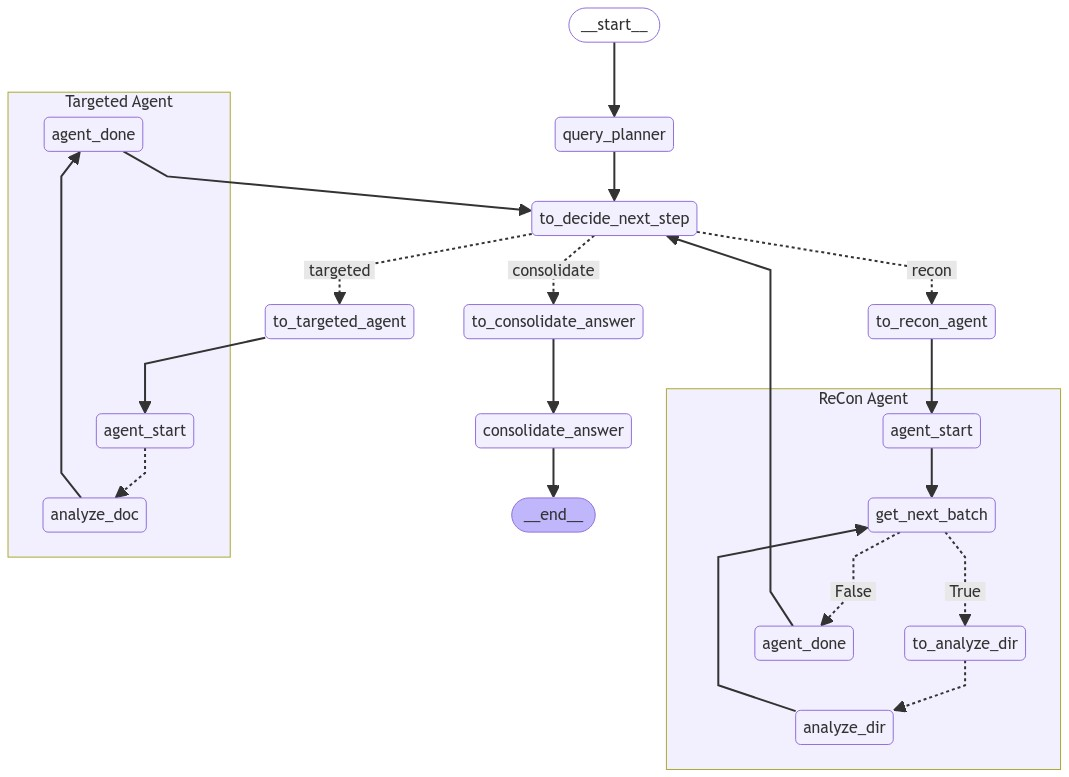

In [247]:
from IPython.display import Image, display

try:
    display(Image(overall_graph.get_graph(xray=True).draw_mermaid_png()))
except Exception as e:
    # This requires some extra dependencies and is optional
    print(e)